# Predicción Automática de Correctitud de Pasajes Textuales Respecto a Preguntas Médicas

### Autores: Luis Ardévol Mesa y Carlos Martínez García

En este trabajo se pretende evaluar la correctitud de pasajes textuales (de tamaño parrafo o similar) respecto a una pregunta médica concreta de forma automática. Para ello, se parte de un conjunto de pasajes procedentres de páginas *web* y relacionados con una serie de preguntas médicas (numeradas entre el 1 y el 50). Para cada pregunta médica, un pasaje puede ser correcto o incorrecto. La colección se encuentra divida en conjunto de entrenamiento y *test*. Para el conjunto de entrenamiento se dispone tanto del texto de la pregunta médica como del pasaje relacionado y la respectiva etiqueta de correctitud. Para el conjunto de *test* solo se dispone del texto de la pregunta y el pasaje relacionado (aquí es donde debemos hacer las estimaciones de correctitud).

## Organización del trabajo

Blablabla

## Soluciones al problema de predicción

### Introducción

Aquí simplemente se tienen unas breves líneas de código que comprueban que tenemos el entorno de trabajo bien configurado para el desarrollo del proyecto. A lo largo del mismo, recurrimos a las siguientes librerías:
* [PyTorch](https://pytorch.org/docs/stable/index.html):
* [Pandas](https://pandas.pydata.org/docs/user_guide/index.html):
* [Transformers](https://github.com/huggingface/transformers):
* [NumPy](https://numpy.org/doc/stable/):
* [spaCy](https://spacy.io/usage):
* [scikit-learn](https://scikit-learn.org/stable/user_guide.html):
* [seaborn]()

Las siguientes librerias también se usan a lo largo del proyecto, pero son parte de la biblioteca estándar de python:
* [re](https://docs.python.org/es/3/library/re.html):
* [string](https://docs.python.org/3/library/string.html):
* [ast](https://docs.python.org/3/library/ast.html):

In [1]:
import subprocess
import sys
import pkg_resources
from packaging import version

def check_and_install_packages():
    required_packages = {
        'torch': 'torch',
        'pandas': 'pandas',
        'transformers': 'transformers',
        'accelerate': 'accelerate>=0.26.0',  # Agregado con versión mínima
        'numpy': 'numpy',
        'spacy': 'spacy',
        'scikit-learn': 'scikit-learn',
        'sentencepiece': 'sentencepiece',
        'xgboost': 'xgboost',
        'imblearn': 'imblearn',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn',
        'datasets': 'datasets'
    }
    
    missing_packages = []
    upgrade_packages = []
    
    # Verificar paquetes instalados y sus versiones
    installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    
    for package, pip_name in required_packages.items():
        if '>' in pip_name or '<' in pip_name or '=' in pip_name:
            # Manejar requisitos de versión
            pkg_name, pkg_version = pip_name.split('>=') if '>=' in pip_name else (pip_name, None)
            pkg_key = package.lower()
            if pkg_key in installed_packages:
                if pkg_version and version.parse(installed_packages[pkg_key]) < version.parse(pkg_version):
                    upgrade_packages.append(pip_name)
            else:
                missing_packages.append(pip_name)
        else:
            # Paquetes sin requisitos de versión específicos
            if package.lower() not in installed_packages:
                missing_packages.append(pip_name)
    
    # Instalar paquetes faltantes
    if missing_packages:
        print("Instalando paquetes necesarios...")
        for package in missing_packages:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print("Instalación completada.")
    else:
        print("Todos los paquetes necesarios ya están instalados.")
    
    # Actualizar paquetes que no cumplen con la versión requerida
    if upgrade_packages:
        print("Actualizando paquetes a las versiones requeridas...")
        for package in upgrade_packages:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print("Actualización completada.")
    else:
        print("Todas las versiones de los paquetes están actualizadas.")
    
    # Verificar si el modelo 'en_core_web_sm' está instalado
    try:
        import spacy
        spacy.load('en_core_web_sm')
        print("El modelo 'en_core_web_sm' de spaCy ya está instalado.")
    except OSError:
        print("Descargando el modelo 'en_core_web_sm' de spaCy...")
        subprocess.check_call([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'])
        print("Modelo 'en_core_web_sm' descargado e instalado correctamente.")

check_and_install_packages()

Todos los paquetes necesarios ya están instalados.
Todas las versiones de los paquetes están actualizadas.
El modelo 'en_core_web_sm' de spaCy ya está instalado.


Leemos nuestro conjunto de entrenamiento como un `DataFrame` de pandas. Este se dividirá en conjunto de entrenamiento, que denotaremos a lo largo del trabajo como *train*, y conjunto de validación, para evaluar la precisión de los modelos desarrollados sobre datos nuevos, que no haya visto. Añadiremos al DataFrame una columna `topic_text` con el texto asociado a cada tópico, que sacamos de un archivo `.xml` que se nos proporciona.

In [2]:
import pandas as pd 
import xml.etree.ElementTree as ET

ruta_entrenamiento = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/ficheros necesarios/training_data.csv'
df = pd.read_csv(ruta_entrenamiento, sep=' ')

def get_topics_from_xml(data, xml_file):
    # parseado del archivo XML
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Crear un diccionario para mapear número a descripción
    number_to_description = {}
    for topic in root.findall('topic'):
        number = topic.find('number').text.strip()
        description = topic.find('description').text.strip()
        number_to_description[number] = description

    # creamos un diccionario con un 'mapa' de número de topico a descripción
    number_to_description = {int(k): v for k, v in number_to_description.items()}
    data.insert(1, 'topic_text', data['topic'].map(number_to_description))
    return data

xml_file = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/ficheros necesarios/misinfo-2020-topics-filtered.xml'

df = get_topics_from_xml(df, xml_file)
df

,topic,topic_text,docId,correctness,passage
0,1,Can vitamin D cure COVID-19?,0113bb03-2a3a-4602-9394-d2fe911b624a,0,Tyler Perry Reveals Role Vitamin D Plays In Fi...
1,1,Can vitamin D cure COVID-19?,015c98bf-8632-4537-9038-7bc3e128cb97,0,This is why you should include Vitamin C and Z...
2,1,Can vitamin D cure COVID-19?,01e198e3-ec00-432d-92f0-cca8251db33d,0,Supplements for Coronavirus Probably Won’t Hel...
3,1,Can vitamin D cure COVID-19?,02700110-5195-4cee-b584-8fe6d870e2dd,0,Coronavirus: Top ways to protect yourself from...
4,1,Can vitamin D cure COVID-19?,02fb6095-115b-4418-bb34-8b76cc65059c,0,Coronavirus: It’s Time to Debunk Claims That V...
...,...,...,...,...,...
3490,25,Can high temperatures and humidity prevent COV...,fade068e-5598-4a5b-b194-fb90885c84a2,0,Would COVID-19 end in summer?: The DONG-A ILBO...
3491,25,Can high temperatures and humidity prevent COV...,fb6a1e79-37cf-4cbd-ad3f-48fa25dcf9ab,1,Coronavirus MORE POWERFUL than first thought a...
3492,25,Can high temperatures and humidity prevent COV...,fe95c08a-a416-44e9-b564-612daff46542,0,Good News: Chinese Scientists have Proven that...
3493,25,Can high temperatures and humidity prevent COV...,fef130d2-df1f-480b-9d0f-d34c6b247ab6,0,Don't Count on Warmer Weather to Curb COVID-19...


### Preprocesado de los datos textuales 

El preprocesamiento de los datos textuales es muy importante, ya que permite eliminar información poco relevante para el modelo, que puede así centrarse en la información que consideremos de mayor importancia para la tarea a realizar. En este caso, eliminaremos URLs, etiquetas HTML y hashtags que se encontraron en una primera exploración de los datos, junto con caracteres no latinos (nuestro modelo estará diseñado para el inglés, por lo que palabras en otros idiomas o caracteres de un alfabeto distinto no tienen gran relevancia). 

También realizamos una normalización del texto y eliminación de caracteres de poco valor: en tareas de clasificación de texto, los caracteres especiales y signos de puntuación genera cierto ruido, por lo que su eliminación resulta, en general, una buena práctica, ya que permite al modelo posterior focalizarse en las palabras. Además, convertir el texto a minúsculas reduce la variabilidad de palabras, ya que, en caso contrario, una palabra en minúscula se trataría como diferente a la misma palabra en mayúscula (muchos modelos no tienen este problema, pero hacerlo de antemano facilita el trabajo posterior de los mismos). Una eliminación de las *stop words* también resulta necesaria en casi cualquier tarea de NLP.

Otra forma de mejorar, en general, la precisión en tareas como la clasificación de texto es la lematización. Este proceso consiste en reducir las palabras a su forma base. Es decir, este proceso es una normalización de los términos pertenecientes a una misma familia y son, por tanto, próximos en significado. Reducir estas palabras a la forma base (o lema) ayuda a reducir la dimensionalidad del problema y en muchos casos mejora la precisión.

Para la primera parte, usaremos la librería de expresiones regulares `re`, que permite eliminar la información poco relevante. Para ello usamos la función `sub`, que sustituirá los patrones elegidos (URLs, hashtags, etiquetas HTML, etc) por una cadena de texto vacia, '', lo que equivale a eliminar los patrones. La función `.lower()` pasa el texto a minúscula y, con `translate` simplemente hacemos la traducción reflejada en la tabla de traducción generada con `str.maketrans()`, que mapea los signos de puntuación (contenidos en la constante `string.punctuation`) a una cadena de texto vacía.

Para lematizar y filtrar *stop words*, usaremos la librería spaCy, que proporciona modelos (*pipelines* concretamente) de NLP en inglés. Concretamente, usaremos `en_core_web_sm`, que es un *pipeline* ligero diseñado para ser rápido al ejecutarse en CPU. Tokenizar el texto con este modelo nos permite luego usar la función `.is_stop` para filtrar las *stop words* del idioma y, sobre las que pasen este filtro, aplicar `.lemma_` para lematizar y obtener la forma base de la misma. Todo esto se guarda en una lista y se termina por concatenar los *tokens* de las palabras en el `return` de la función `clean_text`. 

La función `clean_text` toma como único parámetro la cadena de texto a limpiar, así que la aplicamos a la columna 'passage' con el método `.apply()` para generar una nueva columna con los pasajes preprocesados, 'cleaned_passage'.

In [3]:
import spacy
import re
import string

# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm')

# Función para limpiar el texto
def clean_text(text):
    # Eliminar HTML y URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)
    # Eliminar caracteres no latinos
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Eliminar caracteres especiales y puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convertir a minúsculas
    text = text.lower()

    # Reemplazar múltiples espacios por un solo espacio
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Procesar el texto con spaCy
    doc = nlp(text)
    
    # Eliminar stop words y lematizar
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

# Ejemplo de texto
df['cleaned_passage'] = df['passage'].apply(clean_text)

# Mostrar los primeros elementos de la columna limpiada
df.to_csv('df.csv', index=False)
df

,topic,topic_text,docId,correctness,passage,cleaned_passage
0,1,Can vitamin D cure COVID-19?,0113bb03-2a3a-4602-9394-d2fe911b624a,0,Tyler Perry Reveals Role Vitamin D Plays In Fi...,tyler perry reveal role vitamin d play fight c...
1,1,Can vitamin D cure COVID-19?,015c98bf-8632-4537-9038-7bc3e128cb97,0,This is why you should include Vitamin C and Z...,include vitamin c zinc daily diet orissapost h...
2,1,Can vitamin D cure COVID-19?,01e198e3-ec00-432d-92f0-cca8251db33d,0,Supplements for Coronavirus Probably Won’t Hel...,supplement coronavirus probably will not help ...
3,1,Can vitamin D cure COVID-19?,02700110-5195-4cee-b584-8fe6d870e2dd,0,Coronavirus: Top ways to protect yourself from...,coronavirus way protect vaccine develop mirror...
4,1,Can vitamin D cure COVID-19?,02fb6095-115b-4418-bb34-8b76cc65059c,0,Coronavirus: It’s Time to Debunk Claims That V...,coronavirus time debunk claim vitamin c cure m...
...,...,...,...,...,...,...
3490,25,Can high temperatures and humidity prevent COV...,fade068e-5598-4a5b-b194-fb90885c84a2,0,Would COVID-19 end in summer?: The DONG-A ILBO...,covid end summer donga ilbo content pdf voda n...
3491,25,Can high temperatures and humidity prevent COV...,fb6a1e79-37cf-4cbd-ad3f-48fa25dcf9ab,1,Coronavirus MORE POWERFUL than first thought a...,coronavirus powerful thought terrify superspre...
3492,25,Can high temperatures and humidity prevent COV...,fe95c08a-a416-44e9-b564-612daff46542,0,Good News: Chinese Scientists have Proven that...,good news chinese scientist prove warm weather...
3493,25,Can high temperatures and humidity prevent COV...,fef130d2-df1f-480b-9d0f-d34c6b247ab6,0,Don't Count on Warmer Weather to Curb COVID-19...,not count warm weather curb covid skip main co...


### Primera aproximación (entrega 2024-11-08)

El enfoque inicial del proyecto pasa por buscar una representación vectoriales lo suficientemente buena para que un modelo de clasificación posterior pueda dar resultados precisos. Se decide comenzar por tres aproximaciones:

* Tokenizador del modelo [BioMedLM](https://huggingface.co/stanford-crfm/BioMedLM), [[Ref1]](https://arxiv.org/pdf/2403.18421). Este es un modelo de lenguaje de 2.7B de parámetros entrenado sobre textos médicos, por lo que su uso es costoso pero debería dar representaciones de las palabras de calidad. Un fine-tuning del mismo se escapa del alcance del proyecto. Lo obtenemos como `from transformers import AutoModelForCausalLM`. Al ser un modelo de tipo `GPT2LMHeadModel`, también importaremos este para futuras verificaciones de parámetros. 
* Tokenizador del modelo [Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT), [[Ref2]](https://arxiv.org/pdf/2308.03782). Este modelo tipo BERT fue inicializado a partir de otro modelo, [BioBERT](https://arxiv.org/abs/1901.08746), y entrenado sobre notas clínicas. Esto hace que las representaciones puedan ser más acertadas, al haberse entrenado con un uso más conciso del lenguaje. En esta primera aproximación, no realizamos un fine-tuning del modelo. Lo obtenemos como `from transformers import BertModel`
* [Vectorizador TF-IDF](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): nos permite obtener una matriz *sparse* de características TF-IDF. Puede resultar útil si para la predicción de la correctitud de pasajes podemos dejar a un lado el lenguaje médico y centrarnos solo en las propias palabras.

Los dos modelos presentan un problema evidente ante nuestros pasajes, y es que solo son capaces de procesar 512 *tokens* de una sola pasada. Para poder procesar los pasajes con una longitud mayor, se dividirán en partes o *chunks*, se tokenizan y posteriormente se recombinan los embeddings de las partes pertenecientes a un único pasaje mediante una capa de atención que depende de la dimensión del modelo. 

A continuación se crea la capa de atención para cada modelo. Se crea a partir de la clase base pra todos los modelos neuronales de PyTorch, [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). El método constructor de nuestra clase recupera el constructor de `Module` e implementa una capa lineal que dará una puntuación o 'atención' a cada vector de *embedding*. Para ello, debe conocer la dimensión de los *embeddings* a aplicar, especificada como `embed_dim`. 

El método `forward` debe sobreescribirse en todas las subclases basadas en `Module`. Para ello, `self.attention(embeddings)` aplica la capa lineal antes descrita a cada vector de *embedding* de entrada. A esto, se le aplica una `softmax` para transformar esas puntuaciones a probabilidades que, agregadas, sumen 1. Si en este caso se usara otra función, como una ReLU o una tanh, no tendríamos una distribución de probabilidad consistente. Para terminar, el método `forward` devuelve un único vector de caracaterísticas obtenido como la suma ponderada de los *embeddings* de los *chunks* de un pasaje. 

Como es importante que todas estas operaciones se realicen con tensores de `PyTorch` y, en consecuencia, métodos matemáticos de `PyTorch` adaptados a los mismos, la función `combine_embeddings_attention` se encarga de convertir los *embeddings* a tensores de esta librería. Además, los pasa por la capa de atención y los devuelve en formato NumPy, para un tratamiento más familiar. 

Estamos usando dos modelos distintos, por lo que la dimensión de los *embeddings* no tiene por qué ser el mismo (de hecho, tras la ejecución de la siguiente celda veremos que no son iguales). La dimensión de los *embeddings* es fundamental para definir la capa de atención, por lo que es necesario obtener las dimensiones de cada modelo. Para ello, basta con cargar los dos modelos desde sus respectivos repositorios y usar `modelo.config.hidden_size` para extraer la dimensión de los *embeddings*. 

Para terminar, se definen las instancias `attention_layer_biomed` y `attention_layer_bert`, que representan las capas de atención de los dos modelos a emplear en esta primera aproximación.

In [4]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, BertModel, GPT2LMHeadModel
import numpy as np

class Attention(nn.Module):
    def __init__(self, embed_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(embed_dim, 1)

    def forward(self, embeddings):
        weights = torch.softmax(self.attention(embeddings), dim=0)
        weighted_sum = torch.sum(weights * embeddings, dim=0)
        return weighted_sum
    
def combine_embeddings_attention(embeddings, attention_layer):
    embeddings_tensor = torch.tensor(embeddings)
    return attention_layer(embeddings_tensor).detach().numpy()

# tamaño del embedding para BioMedLM
biomed_model = AutoModelForCausalLM.from_pretrained("stanford-crfm/BioMedLM")
embed_dim_biomed = biomed_model.config.hidden_size
print(f"El tamaño del embedding para BioMedLM es {embed_dim_biomed}")

# tamaño del embedding para ClinicalBERT
bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2)
embed_dim_bert = bert_model.config.hidden_size
print(f"El tamaño del embedding para ClinicalBERT es {embed_dim_bert}")


attention_layer_biomed = Attention(embed_dim=embed_dim_biomed)
attention_layer_bert = Attention(embed_dim=embed_dim_bert)

/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


El tamaño del embedding para BioMedLM es 2560
El tamaño del embedding para ClinicalBERT es 768


A continuación, definimos dos funciones: 

* `split_into_chunks` será la encargada de dividir los pasajes en bloques de 512 *tokens*. Tomará como argumentos el pasaje, el tokenizador del modelo, y el máximo de *tokens*, que será por defecto el máximo, 512. La función tokeniza el pasaje y genera una lista donde los elementos son los bloques que posteriormente se darán al modelo.

* `process_text` procesa los fragmentos y combina los resultados. Esta función toma como argumentos el pasaje, el tokenizador, el modelo, la capa de atención, un índice (simplemente para indicar el progreso). Se comienza dividiendo el pasaje en bloques, con la función `split_into_chunks`. Para cada bloque:
    * Convertimos los tokens del fragmento en sus representaciones numéricas (IDs) y creamos un tensor con ellos y lo movemos al dispositivo donde lo estamos procesando (cpu en este caso). Al no estar haciendo *fine-tuning* de los modelos, desactivamos el cálculo de gradiente para actualizar los pesos. 
    * La extracción del *token* [CLS] es una práctica común al usar modelos de tipo BERT. Este *token* refleja el contexto y las relaciones presentes en el texto, dando información relevante que ayuda al modelo a distinguir entre diferentes categorías. Tenemos una tarea de clasificación binaria, por lo que la primera tentativa es usar esta práctica tan acogida. Para extraer el *embedding* de este *token* debemos acceder a la última capa de estados ocultos y, dependiendo del modelo, este proceso varía:
        * Para BioMedLm, debemos especificar primero que el modelo devuelva los estados ocultos intermedios. Esto se hace estableciendo `output_hidden_states=True`. Tras esto, el *token* [CLS] será el primer elemento de la última capa de estados ocultos.
        * Para Bio_ClinicalBERT, al ser un modelo de tipo BERT, podemos acceder directamente al *embedding* del *token* [CLS].
    El resultado lo movemos a la cpu y, al igual que con la capa de atención, lo convertimos a un objeto de NumPy para manejarlo de forma más cómoda, y lo guardamos en una lista. La función esta pensada para poder incluir modelos de un tipo distinto a estos dos de forma sencilla. Con `np.squeeze()` eliminamos las dimensiones de tamaño 1, al no resultar de utilidad en este caso. 
    * Tras procesar todos los bloques, convertimos la lista de *embeddings* a array de NumPy para pasarla por la capa de atención correspondiente y poder obtener una única representación del pasaje completo mediante la combinación de las representaciones de sus bloques.
La función `process_text` devuelve esta última representación.

In [5]:
device = torch.device('cpu')

# dividir el texto en fragmentos de 512 tokens
def split_into_chunks(text, tokenizer, max_length=512):
    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return chunks

# procesar cada fragmento y combinar los resultados
def process_text(text, tokenizer, model, attention_layer):
    assert isinstance(text, str), "'text' debe ser una cadena de texto" 
    assert hasattr(tokenizer, 'convert_tokens_to_ids'), "'tokenizer' debe ser un tokenizador de Hugging Face"
    assert isinstance(attention_layer, Attention), "'attention_layer' debe ser una capa de atención de la clase Attention"
    
    chunks = split_into_chunks(text, tokenizer)
    embeddings = []

    for chunk in chunks:
        tokens = tokenizer.convert_tokens_to_ids(chunk)
        tokens_tensor = torch.tensor([tokens]).to(device)
        
        # extraer la representación del [CLS] token (primer token, captura la represetnacion semantica de la secuencia)
        with torch.no_grad():
            if isinstance(model, GPT2LMHeadModel):
                outputs = model(tokens_tensor, output_hidden_states=True)
                cls_embedding = outputs.hidden_states[-1][:, 0, :].cpu().numpy()

            elif isinstance(model, BertModel):
                outputs = model(tokens_tensor)
                cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            
            else: 
                raise ValueError("Modelo no soportado")
        
        cls_embedding = np.squeeze(cls_embedding)
        embeddings.append(cls_embedding)
    
    # convertir la lista de arrays de NumPy a un solo array de NumPy
    embeddings_array = np.array(embeddings)

    # combinar las representaciones
    combined_embedding = combine_embeddings_attention(embeddings_array, attention_layer)
    
    return combined_embedding

Con todo el preprocesamiento definido, solo queda tokenizar los pasajes. Para ello necesitamos importar `AutoTokenizer` y `BertTokenizer`, de la librería `transformers`. La función `exec_process` se encargará de llamar a las funciones anteriores para tokenizar los pasajes y guardarlos en la tabla `df` como nuevas columnas. Nos interesa tener este resultado guardado ya que es un proceso lento, no como en el caso de la vectorización con TF-IDF, que es casi inmediata. Devuelve como resultado el DataFrame actualizado con las tokenizaciones.

Esta función tomará un único parámetro obligatorio, el DataFrame de datos. El resto de parámetros serán listas predefinidas, ya que para esta primera aproximación no varían, pero cambiando el valor de los parámetros podemos reciclar convenientemente esta función en caso de querer introducir nuevos modelos. Veamos estos argumentos:
* `modelos = [(biomed_model, 'biomed'), (bert_model, 'bioclinicalbert')]`. Este parámetro debe ser una lista de tuplas para nombrar la columna del DataFrame donde se guardarán los resultado; por esto existe el segundo elemento de cada tupla. Lo realmente importante son los modelos que se usarán, que se deben pasar como primer argumento de cada tupla. 
* `tokenizadores=[biomed_tokenizer, bert_tokenizer]`: una lista con los tokenizadores a usar, en el mismo orden que los modelos.
* `attention_layers=[attention_layer_biomed, attention_layer_bert]`: una lista con las capas de atención de los respectivos modelo.

Para minimizar posibles errores en la ejecución, esta función verifica de forma exhaustiva los argumentos de entrada. Una vez hecho todo esto, solo quedar iterar sobre cada modelo, aplicando la función `.progress_apply()` sobre la columna de pasajes preprocesados 'cleaned_passage', especificando nuestra función para tokenizar los textos por bloques `process_text` como función a usar por `.progress_apply()` (muestra el progreso del ejecución); esta aplicación elemento a elemento se consigue de forma compacta gracia a la función `lambda`. 

Cada vez que se termina con un la tokenización de un modelo, se guarda la nueva tabla en formato .csv. Antes de guardarla, se convierten los arrays de NumPy a listas, ya que un archivo plano no puede guardar un array de NumPy manteniendo sus propiedades. Al abrir los archivos .csv y leer los datos, habrá que hacer el proceso inverso. Esta es una solución *ad-hoc*, ya que al guardar los arrays de NumPy en .csv se observó que, al leer de nuevo el archivo para usar las tokenizaciones, se obtenian como `str`, complicando en gran medida su reconversión a tipo NumPy.

Para indicar el progreso, también haremos uso del módulo [tqdm](https://tqdm.github.io), que nos permite mostrar una barra de progreso en la terminal.

In [6]:
from transformers import AutoTokenizer, BertTokenizer
from tqdm import tqdm

tqdm.pandas()

# cargamos el tokenizador de BioMedLM y Bio_ClinicalBERT
biomed_tokenizer = AutoTokenizer.from_pretrained("stanford-crfm/BioMedLM")
bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

def exec_process(data, modelos=[(biomed_model, 'biomed'), (bert_model, 'bioclinicalbert')], tokenizadores=[biomed_tokenizer, bert_tokenizer], attention_layers=[attention_layer_biomed, attention_layer_bert], filename='embeddings.csv'):
    assert isinstance(data, pd.DataFrame), "'data' debe ser un DataFrame de pandas"
    assert isinstance(modelos, list), "'modelos' debe ser una lista"
    assert isinstance(tokenizadores, list), "'tokenizadores' debe ser una lista"
    assert isinstance(attention_layers, list), "'attention_layers' debe ser una lista"
    assert len(modelos) == len(tokenizadores) == len(attention_layers), "Las listas 'modelos', 'tokenizadores' y 'attention_layers' deben tener la misma longitud"
    
    assert all(isinstance(modelo, tuple) and len(modelo) == 2 and isinstance(modelo[1], str) 
               for modelo in modelos), "Cada elemento de 'modelos' debe ser una tupla con al menos dos elementos, donde el segundo es un string"

    # Procesar cada pasaje y obtener los embeddings
    for ii in range(len(modelos)):
        model, model_name = modelos[ii]
        tokenizador = tokenizadores[ii]
        capa_atencion = attention_layers[ii]
        col_name = f'{model_name}_embeddings'

        data[col_name] = data.progress_apply(lambda row: process_text(row['cleaned_passage'], tokenizer=tokenizador, model=model, attention_layer=capa_atencion), axis=1)
        data[col_name] = data[col_name].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
    
        # Guardar el DataFrame como un archivo CSV
        data.to_csv(f'{filename}.csv', index=False)

    return data

A continuación, simplemente ejecutamos la función anterior sobre el DataFrame que contiene los pasajes

In [7]:
data_embeddings = exec_process(df, filename='embeddings')

100%|██████████| 3495/3495 [09:41<00:00,  6.01it/s]


Leemos el archivo con los datos de los *embeddings* generados antes.

In [19]:
ruta_embeddings = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/embeddings.csv'
data_embeddings = pd.read_csv(ruta_embeddings)
data_embeddings.head()

,topic,topic_text,docId,correctness,passage,cleaned_passage,biomed_embeddings,bioclinicalbert_embeddings
0,1,Can vitamin D cure COVID-19?,0113bb03-2a3a-4602-9394-d2fe911b624a,0,Tyler Perry Reveals Role Vitamin D Plays In Fi...,tyler perry reveal role vitamin d play fight c...,"[-0.4583433270454407, -0.7408691644668579, -1....","[-0.3204018771648407, -0.8082979321479797, -0...."
1,1,Can vitamin D cure COVID-19?,015c98bf-8632-4537-9038-7bc3e128cb97,0,This is why you should include Vitamin C and Z...,include vitamin c zinc daily diet orissapost h...,"[-1.9723180532455444, -0.04033245891332626, -2...","[-0.29766371846199036, -0.8551684617996216, -0..."
2,1,Can vitamin D cure COVID-19?,01e198e3-ec00-432d-92f0-cca8251db33d,0,Supplements for Coronavirus Probably Won’t Hel...,supplement coronavirus probably will not help ...,"[-0.6690548658370972, 0.48831698298454285, -0....","[0.03967305272817612, -0.708490788936615, -1.0..."
3,1,Can vitamin D cure COVID-19?,02700110-5195-4cee-b584-8fe6d870e2dd,0,Coronavirus: Top ways to protect yourself from...,coronavirus way protect vaccine develop mirror...,"[1.3874061107635498, -0.31939730048179626, -0....","[-0.3909864127635956, -0.7827029228210449, -0...."
4,1,Can vitamin D cure COVID-19?,02fb6095-115b-4418-bb34-8b76cc65059c,0,Coronavirus: It’s Time to Debunk Claims That V...,coronavirus time debunk claim vitamin c cure m...,"[1.5861400365829468, -0.59348064661026, -0.696...","[-0.32800403237342834, -0.8866564035415649, -0..."


El primer paso para desarrollar cualquier modelo es la división de los datos de entrada. Dividiremos el conjunto de entrenamiento en conjuntos de *train* (80%) y validación (20%). Para ello usamos la función `train_test_split`, que separa los conjuntos de forma aleatoria (para que los resultados sean reproducibles fijamos un estado aleatorio concreto). Además, estratificamos con las etiquetas de correctitud para que la proporción de correctos e incorrectos sea la misma en ambos conjuntos.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data_embeddings, test_size=0.2, random_state=42, stratify=data_embeddings['correctness'])

Ya comentamos antes el problema de guardar los *embeddings* en el DataFrame. Ahora, para resolver problemas de lectura y poder recuperar cada una en formato array de NumPy, recurrimos a la función `literal_eval`, que permite evaluar una expresión que contenga estructuras literales de Python. Esto permite castear los *embeddings* a una lista y, posteriormente, a un array de NumPy. A continuación, separamos los conjuntos de *train* y validación de las variables dependientes (*correctness*) e independientes (*embeddings*) de cada modelo usado; seguimos el proceso antes descrito para tener los vectores de *embeddings* en el formato buscado. 

Además, generamos las vectorizaciones TF-IDF (usando `TfidfVectorizer` de `sklearn`). Simplemente definimos el vectorizador y ajustamos y transformamos los pasajes haciendo uso del mismo. Es importante tener en cuenta que el conjunto de datos de validación debe compartir el mismo espacio de caracteristicas que el conjunto de *train*, es decir, debe usar `vectorizer` como vectorizador, y sobre el conjunto de datos solo aplicaremos un `transform`. Para minimizar problemas con las palabras no vistas, definimos un amplio número de características y lematizamos el texto con anterioridad. Entre la reducción de dimensionalidad que aporta la lematización y el número de características seleccionadas, se espera una buena solución para el control de nuevas palabras.

Para predecir usaremos los *embeddings* generados por los modelos BioMedLM y Bio_ClinicalBERT, además de la vectorización TF-IDF del conjunto de pasajes. Las etiquetas de correctitud son, como es lógico, las mismas para los tres conjuntos. 

In [ ]:
import ast
from sklearn.feature_extraction.text import TfidfVectorizer

# etiquetas
y_train = train_data['correctness']
y_val = val_data['correctness']

# modelo biomedlm
X_biomedlm_train = np.array(train_data['biomed_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())
X_biomedlm_val = np.array(val_data['biomed_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo bioclinicalbert
X_bioclinical_train = np.array(train_data['bioclinicalbert_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())
X_bioclinical_val = np.array(val_data['bioclinicalbert_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo tfidf (convertimos matriz sparse a matriz densa)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf_train = vectorizer.fit_transform(train_data['cleaned_passage']).toarray()
X_tfidf_val = vectorizer.transform(val_data['cleaned_passage']).toarray()

In [23]:
print(type(X_biomedlm_train), X_biomedlm_train.shape)
print(type(X_bioclinical_train), X_bioclinical_train.shape)
print(type(X_tfidf_train), X_tfidf_train.shape)

print(type(X_biomedlm_val), X_biomedlm_val.shape)
print(type(X_bioclinical_val), X_bioclinical_val.shape)
print(type(X_tfidf_val), X_tfidf_val.shape)

<class 'numpy.ndarray'> (2796, 2560)
<class 'numpy.ndarray'> (2796, 768)
<class 'numpy.ndarray'> (2796, 5000)
<class 'numpy.ndarray'> (699, 2560)
<class 'numpy.ndarray'> (699, 768)
<class 'numpy.ndarray'> (699, 5000)


Tras la división de los datos disponibles, convendría entrenar los modelos de clasificación a usar y, posteriormente, hacer predicciones sobre los datos de validación, para hacernos una idea de la precisión de los mismos sobre nuevos datos. 

### Modelos de clasificación

En lo que resta de sección nos centraremos en probar distintos modelos de clasificación, haciendo uso de los *embeddings* y la vectorización obtenidos anteriormente para cada pasaje. Esta es una forma de ver qué modelos nos están dando unas representaciones más informativas, cuáles se pueden mejorar, o incluso si podemos combinar las predicciones para obtener resultados más precisos. 

Como queremos probar con varios modelos, para entrenar definimos la función `modelosClasificacion`, que toma como argumentos el conjunto de *train* de los predictores y predictandos, y el tipo de modelo a probar como `type_model`. Se han implementado los siguientes modelos:
* 'lr': [Regresión logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): explicar un poquito y porque se toman los parametros que se toman.
* 'rf': [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): explicar un poquito.
* 'svm': [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): explicar un poquito.
* 'xgb': [XGBoost](https://xgboost.readthedocs.io/en/latest/python/index.html): explicar un poquito.
* (Meter en la segunda aprox?) 'mlp': [Perceptrón multicapa](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html): explicar un poquito.

La función simplemente hace un `.fit` del modelo seleccionado a los datos de entrenamiento y devuelve el modelo entrenado, para usarlo posteriormente en la predicción. En esta aproximación no se hace una búsqueda de hiperparámetros, esto se implementará más adelante.

El modelo entrenado se guarda en la ruta 'modelos/' con un nombre que refleja el modelo y el tipo de representación usada, que se especifica con el parámetro `data_type`.

Definimos también una función `cargar_modelo` que simplemente carga el modelo entrenado (en la ruta 'modelos/') con el nombre dado en el parámetro `filename` si la variable que da nombre al modelo no está ya definida. Es decir, comprueba si existe una variable con el nombre `variable_name` y, en caso de no existir, devuelve el modelo; si existe, devuelve esa variable. Si bien sencilla, esta función está diseñada para facilitar y simplificar la carga de modelos en el futuro (y evitar sobreescribir modelos ya en uso).

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib
import os


def modeloClasificacion(x_train, y_train, type_model, data_type, max_iter=100000, kernel='linear', nest=100, random_state=42):

    assert x_train is not None and y_train is not None, "Datos de entrenamiento no proporcionados"
    assert type_model in ['lr', 'svm', 'rf', 'xgb'], "Modelo no válido"

    # Inicializar modelo base
    if type_model == 'lr':
        model = LogisticRegression(max_iter=max_iter)
    elif type_model == 'svm':
        model = SVC(kernel=kernel, probability=True)
    elif type_model == 'rf':
        model = RandomForestClassifier(n_estimators=nest, random_state=random_state)
    elif type_model == 'xgb':
        model = XGBClassifier(eval_metric='logloss', random_state=random_state)

    model.fit(x_train, y_train)

    # Guardar el modelo en un archivo
    os.makedirs('modelos', exist_ok=True)
    joblib.dump(model, f'modelos/{type(model).__name__}_{data_type}_entrenado.pkl')
        
    return model

def cargar_modelo(filename, variable_name):
    assert isinstance(filename, str), "El nombre del archivo debe ser un string"
    return joblib.load('modelos/{filename}.pkl') if variable_name not in globals() else globals()[variable_name]

Entrenamos 12 modelos distintos: usamos los 4 modelos de clasificación implementados sobre los tres conjuntos de datos disponibles, los *embeddings* y la matriz TF-IDF.

In [25]:
modelo_lr_biomedlm = modeloClasificacion(X_biomedlm_train, y_train, type_model='lr', data_type='biomedlm')
modelo_lr_bioclinical = modeloClasificacion(X_bioclinical_train, y_train, type_model='lr', data_type='bioclinical')
modelo_lr_tfidf = modeloClasificacion(X_tfidf_train, y_train, type_model='lr', data_type='tfidf')

modelo_svm_biomedlm = modeloClasificacion(X_biomedlm_train, y_train, type_model='svm', data_type='biomedlm')
modelo_svm_bioclinical = modeloClasificacion(X_bioclinical_train, y_train, type_model='svm', data_type='bioclinical')
modelo_svm_tfidf = modeloClasificacion(X_tfidf_train, y_train, type_model='svm', data_type='tfidf')

modelo_rf_biomedlm = modeloClasificacion(X_biomedlm_train, y_train, type_model='rf', data_type='biomedlm')
modelo_rf_bioclinical = modeloClasificacion(X_bioclinical_train, y_train, type_model='rf', data_type='bioclinical')
modelo_rf_tfidf = modeloClasificacion(X_tfidf_train, y_train, type_model='rf', data_type='tfidf')

modelo_xgb_biomedlm = modeloClasificacion(X_biomedlm_train, y_train, type_model='xgb', data_type='biomedlm')
modelo_xgb_bioclinical = modeloClasificacion(X_bioclinical_train, y_train, type_model='xgb', data_type='bioclinical')
modelo_xgb_tfidf = modeloClasificacion(X_tfidf_train, y_train, type_model='xgb', data_type='tfidf')

A continuación, definimos una función muy sencilla que evalúa la precisión de un modelo concreto. La función `evaluacion` toma como parámetros las etiquetas de correctitud reales y las predicciones del modelo a evaluar, y devuelve la puntuación de *accuracy* del mismo junto con el reporte de clasificación completo. Estas métricas las obtenemos de forma sencilla en `sklearn.metrics` con `accuracy_score` y `classification_report`, respectivamente. 

Además, en tareas de clasificación binaria, una matriz de confusión es una forma muy útil e informativa de representar los resultados. La función `confusion_matrix` de `sklearn.metrics` nos permite calcularla de forma sencilla, y `seaborn` nos da una forma de crear este visual más directa que `matplotlib`. 

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluacion(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred))
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Crear visualización
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Matriz de Confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor Real')
    plt.show()
    return 

Con el modelo entrenado, y una forma de conocer la precisión de sus resultados, solo queda hacer predicciones sobre los datos de validación. Para ello, se define la función `evaluar_modelos`, que toma como argumentos los predictores, `x` y el modelo a evaluar (ya entrenado). Las predicciones se hacen con el método `.predict` del modelo.

Como estas predicciones se harán tanto sobre el conjunto de validación como sobre el conjunto de *test*, debemos hacer que la función sea apta para ambos casos. Esto se hace fijando el argumento correspondiente a las etiquetas, `y`, como `None`. Cuando este valor es no nulo, usamos la función `evaluación` para hacer un reporte de la precisión del modelo. Cuando es nulo, nos interesa guardar las predicciones en un nuevo DataFrame que incluya las siguientes columnas, separadas por espacios:
 
* Las columnas 'topic' y 'docId' del DataFrame original.
* Una columna 'correctness' con las predicciones del modelo.

Para ello, hay que proporcionar los parámetros `data` y `filename`, fijados como `None` por defecto. `data` es el DataFrame de dónde obtenemos las columnas 'topic' y 'docId', y `filename` es el nombre del archivo donde se guardarán las predicciones (por defecto, en la ruta predicciones/filename.csv).

En cualquiera de los dos casos, la función devuelve las predicciones categóricas y las probabilidades asociadas a cada clase. Esto último es útil para hacer una evaluación más exhaustiva del modelo, y se obtiene de forma muy sencilla con el método `.predict_proba` del modelo (si esta disponible).

In [27]:
def predicciones(x, modelo, y=None, data=None, filename=None, evaluation=evaluacion): # debe recibir el x_test_scaled
    assert len(x) == len(y) if y is not None else True, "Las filas de 'x' e 'y' no coinciden"
    assert hasattr(modelo, 'predict'), "Modelo no válido: el modelo no tiene un método 'predict'"

    predicciones = modelo.predict(x) # test (1-25 o 25-50)

    if y is not None:
        print(f"Modelo {type(modelo).__name__}")
        evaluation(y, predicciones)

    # cuando hacemos con datos de TEST (25-50)
    else:
        assert isinstance(data, pd.DataFrame), "'data' debe ser un DataFrame de pandas"
        assert filename is not None, "Se debe especificar un nombre para guardar el archivo"
        df_result = pd.DataFrame({
            'topic': data['topic'],
            'docId': data['docId'],
            'correctness': predicciones
        })

        # Guardar en un archivo CSV con separador de espacio
        os.makedirs('predicciones', exist_ok=True)
        df_result.to_csv(f'predicciones/{filename}.csv', sep=' ', index=False)
    
    if hasattr(modelo, 'predict_proba'):
        return [predicciones, modelo.predict_proba(x)]
    else:
        print(f"El modelo {type(modelo).__name__} no tiene un método 'predict_proba'")
        return predicciones

Vamos a evaluar las predicciones de los 4 modelos de clasificación que usan los *embeddings* o vectorizaciones de cada modelo usado. El proceso será para todos el mismo:
* Primero nos aseguramos de que existan los modelos a usar (cargándolos desde los correspondientes archivos o rescatando la variable en la que se encuentren). 
* A continuación, hacemos las predicciones sobre los datos de validación y evaluamos los resultados.

**BioMedLM**

Modelo LogisticRegression
Accuracy: 0.6352

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       379
           1       0.62      0.51      0.56       320

    accuracy                           0.64       699
   macro avg       0.63      0.63      0.62       699
weighted avg       0.63      0.64      0.63       699



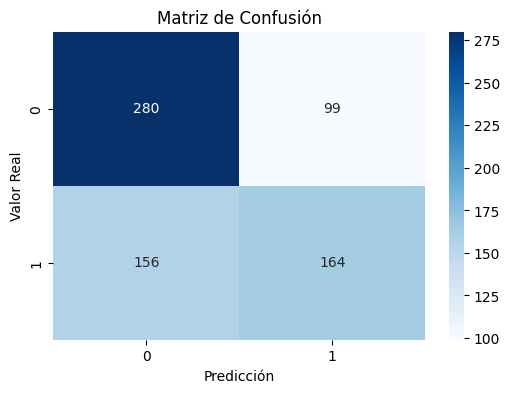

Modelo RandomForestClassifier
Accuracy: 0.6352

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       379
           1       0.63      0.48      0.55       320

    accuracy                           0.64       699
   macro avg       0.63      0.62      0.62       699
weighted avg       0.63      0.64      0.63       699



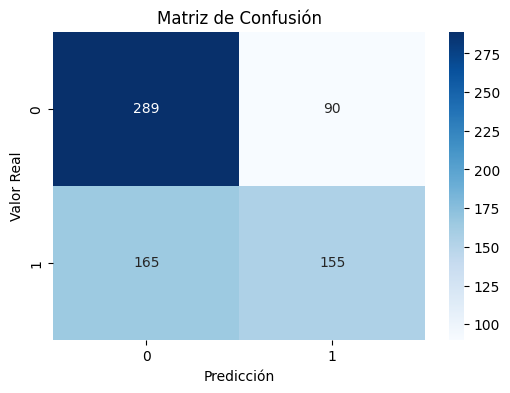

Modelo XGBClassifier
Accuracy: 0.6509

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70       379
           1       0.65      0.51      0.57       320

    accuracy                           0.65       699
   macro avg       0.65      0.64      0.64       699
weighted avg       0.65      0.65      0.64       699



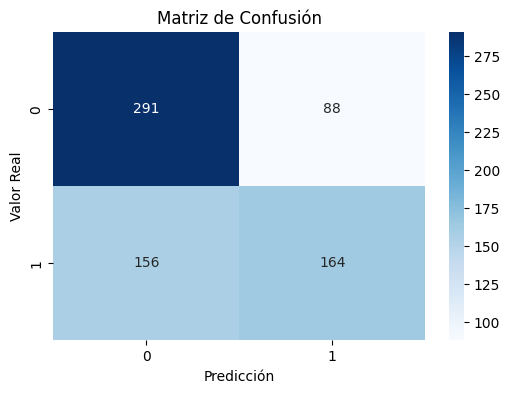

Modelo SVC
Accuracy: 0.6309

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.74      0.68       379
           1       0.62      0.51      0.56       320

    accuracy                           0.63       699
   macro avg       0.63      0.62      0.62       699
weighted avg       0.63      0.63      0.63       699



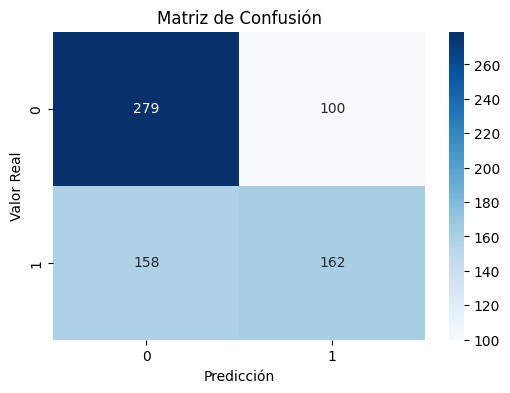

In [65]:
modelo_lr_biomedlm = cargar_modelo('LogisticRegression_biomedlm_entrenado.pkl', 'modelo_lr_biomedlm')
modelo_rf_biomedlm = cargar_modelo('RandomForestClassifier_biomedlm_entrenado.pkl', 'modelo_rf_biomedlm')
modelo_xgb_biomedlm = cargar_modelo('XGBClassifier_biomedlm_entrenado.pkl', 'modelo_xgb_biomedlm')
modelo_svm_biomedlm = cargar_modelo('SVC_biomedlm_entrenado.pkl', 'modelo_svm_biomedlm')

# predicciones
preds_lr_biomedlm = predicciones(X_biomedlm_val, modelo_lr_biomedlm, y=y_val)
preds_rf_biomedlm = predicciones(X_biomedlm_val, modelo_rf_biomedlm, y=y_val)
preds_xgb_biomedlm = predicciones(X_biomedlm_val, modelo_xgb_biomedlm, y=y_val)
preds_svm_biomedlm = predicciones(X_biomedlm_val, modelo_svm_biomedlm, y=y_val)

**Bio_ClinicalBERT**

Modelo LogisticRegression
Accuracy: 0.7053

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       379
           1       0.68      0.68      0.68       320

    accuracy                           0.71       699
   macro avg       0.70      0.70      0.70       699
weighted avg       0.71      0.71      0.71       699



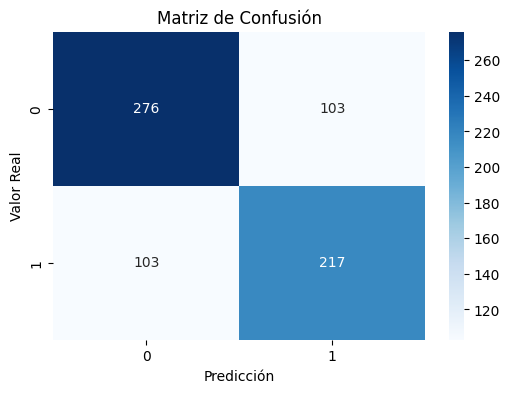

Modelo RandomForestClassifier
Accuracy: 0.6867

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       379
           1       0.69      0.57      0.63       320

    accuracy                           0.69       699
   macro avg       0.69      0.68      0.68       699
weighted avg       0.69      0.69      0.68       699



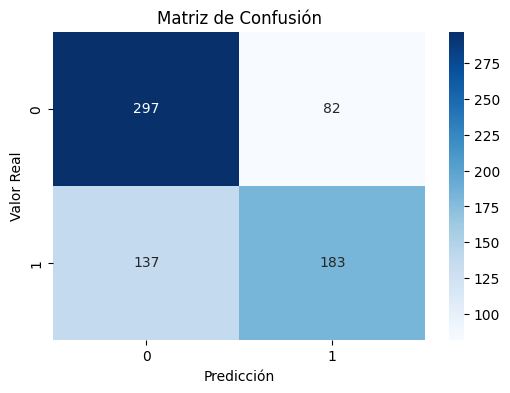

Modelo XGBClassifier
Accuracy: 0.7110

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       379
           1       0.70      0.64      0.67       320

    accuracy                           0.71       699
   macro avg       0.71      0.71      0.71       699
weighted avg       0.71      0.71      0.71       699



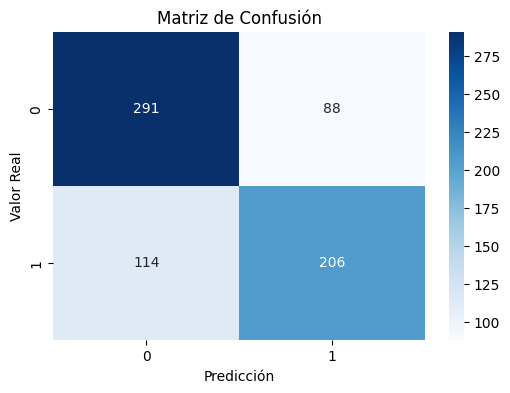

Modelo SVC
Accuracy: 0.7110

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       379
           1       0.69      0.68      0.68       320

    accuracy                           0.71       699
   macro avg       0.71      0.71      0.71       699
weighted avg       0.71      0.71      0.71       699



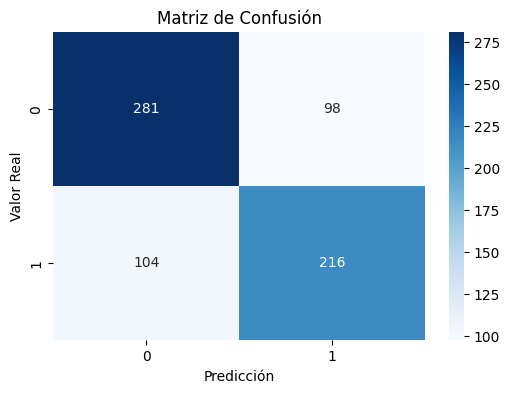

In [64]:
modelo_lr_bioclinical = cargar_modelo('LogisticRegression_bioclinical_entrenado.pkl', 'modelo_lr_bioclinical')
modelo_rf_bioclinical = cargar_modelo('RandomForestClassifier_bioclinical_entrenado.pkl', 'modelo_rf_bioclinical')
modelo_xgb_bioclinical = cargar_modelo('XGBClassifier_bioclinical_entrenado.pkl', 'modelo_xgb_bioclinical')
modelo_svm_bioclinical = cargar_modelo('SVC_bioclinical_entrenado.pkl', 'modelo_svm_bioclinical')

# predicciones
preds_lr_bioclinical = predicciones(X_bioclinical_val, modelo_lr_bioclinical, y=y_val)
preds_rf_bioclinical = predicciones(X_bioclinical_val, modelo_rf_bioclinical, y=y_val)
preds_xgb_bioclinical = predicciones(X_bioclinical_val, modelo_xgb_bioclinical, y=y_val)
preds_svm_bioclinical = predicciones(X_bioclinical_val, modelo_svm_bioclinical, y=y_val)

**TF-IDF**

Modelo LogisticRegression
Accuracy: 0.7768

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       379
           1       0.76      0.75      0.76       320

    accuracy                           0.78       699
   macro avg       0.78      0.77      0.78       699
weighted avg       0.78      0.78      0.78       699



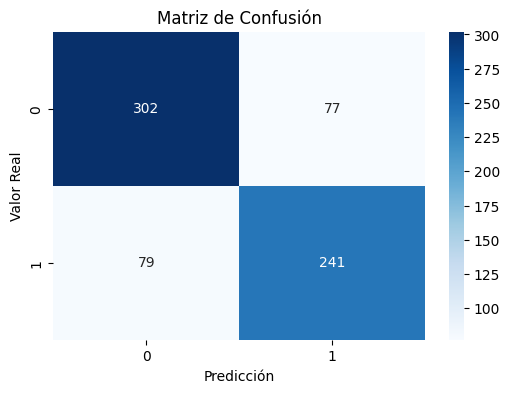

Modelo RandomForestClassifier
Accuracy: 0.7825

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       379
           1       0.78      0.74      0.76       320

    accuracy                           0.78       699
   macro avg       0.78      0.78      0.78       699
weighted avg       0.78      0.78      0.78       699



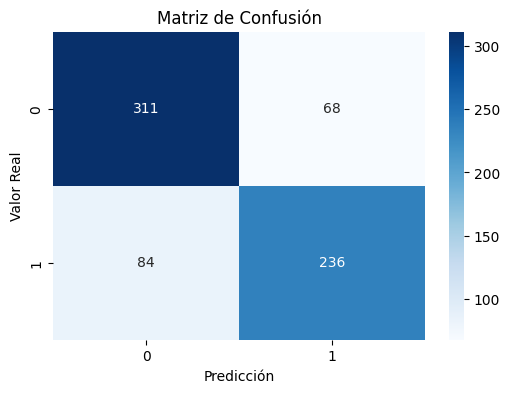

Modelo XGBClassifier
Accuracy: 0.7725

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       379
           1       0.76      0.73      0.75       320

    accuracy                           0.77       699
   macro avg       0.77      0.77      0.77       699
weighted avg       0.77      0.77      0.77       699



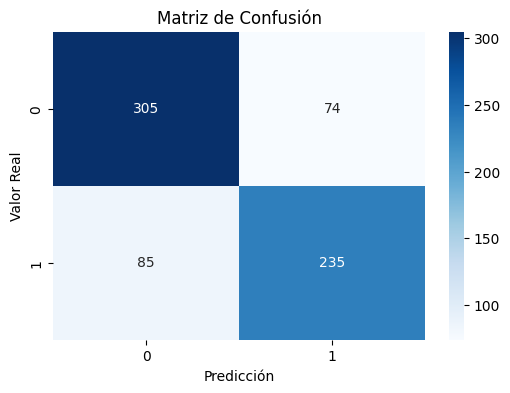

Modelo SVC
Accuracy: 0.7711

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       379
           1       0.75      0.76      0.75       320

    accuracy                           0.77       699
   macro avg       0.77      0.77      0.77       699
weighted avg       0.77      0.77      0.77       699



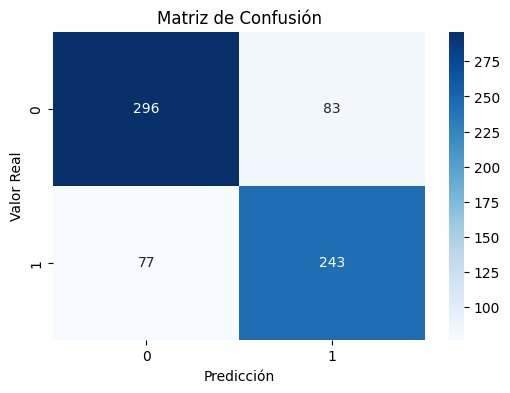

In [63]:
modelo_lr_tfidf = cargar_modelo('LogisticRegression_tfidf_entrenado.pkl', 'modelo_lr_tfidf')
modelo_rf_tfidf = cargar_modelo('RandomForestClassifier_tfidf_entrenado.pkl', 'modelo_rf_tfidf')
modelo_xgb_tfidf = cargar_modelo('XGBClassifier_tfidf_entrenado.pkl', 'modelo_xgb_tfidf')
modelo_svm_tfidf = cargar_modelo('SVC_tfidf_entrenado.pkl', 'modelo_svm_tfidf')

# predicciones
preds_lr_tfidf = predicciones(X_tfidf_val, modelo_lr_tfidf, y=y_val)
preds_rf_tfidf = predicciones(X_tfidf_val, modelo_rf_tfidf, y=y_val)
preds_xgb_tfidf = predicciones(X_tfidf_val, modelo_xgb_tfidf, y=y_val)
preds_svm_tfidf = predicciones(X_tfidf_val, modelo_svm_tfidf, y=y_val)

### Combinación de predicciones

Los *embeddings* dados por BioMedLM y por Bio_ClinicalBERT son de distinta naturaleza, debido al conjunto sobre el que fueron entrenados. Por esto, cada uno captura una parte de la información de cada pasaje. Una combinación de ambas podría dar un modelo más preciso al complementar las carencias mutuas. Con este propósito, indagamos en una aproximación de *ensembles* de los modelos de clasificación [[Ref3]](https://arxiv.org/pdf/1908.09720). Decidimos como primera aproximación probar con estrategias sencillas:

* Votación mayoritaria: se predice la clase que más votos recibe de los modelos individuales. Usa las predicciones categóricas de los modelos.
* Promedio: se promedian las probabilidades de cada clase de los modelos individuales y se predice la clase con mayor probabilidad. Usa las probabilidades de cada categoría en las predicciones de los modelos. Este lo implementamos de dos formas distintas:
    * Promedio simple: se promedian las probabilidades de cada clase de los modelos individuales.
    * Promedio ponderado: se promedian las probabilidades de cada clase de los modelos individuales, pero se pondera cada probabilidad por la precisión del modelo que la ha dado.
    * Mejor promedio ponderado: con pesos de un único decimal y normalizados, se busca entre todas las posibles combinaciones el modelo de mayor *accuracy*. Nótese que esta opción solo se puede usar con los datos de validación. Con los datos de *test* habría que usar los pesos calculados de este forma para hacer un promedio poderado.

Para implementar estas estrategias, definimos la función `combinacion`, que toma como argumentos las predicciones de los modelos individuales, en formato de lista (`modelos`), las etiquetas reales (para el caso del conjunto de *test* este parámetro debe ser None), los pesos `w` como lista para hacer el promedio pesado, y el tipo de estrategia a usar. Las estrategias anteriores se programan como sigue:
* Votación mayoritaria: para cada fila, se hace una lista con las predicciones de los modelos y se toma la categoría que más se repita. En caso de empate, se toma la primera categoría que más se repita (esta estrategia esta sujeta a mejoras).
* Promedio simple: se hace que los pesos sean todos iguales y se promedian las probabilidades de cada clase de los modelos individuales.
* Promedio ponderado: se promedian las probabilidades de cada clase de los modelos individuales, pero se pondera cada probabilidad por el peso correspondiente dado en `w`.
* Mejor promedio ponderado: se hace una lista de los posibles valores de cada peso y, con la función `itertools.product`, se obtienen todas las combinaciones posibles. El parámetro `repeat` nos sirve para especificar el número de veces que se puede repetir cada valor. Luego, nos quedamos solo con las combinaciones normalizadas al número total de modelos ponderados. Posteriormente, se itera sobre las distintas combinaciones posibles de pesos, gurdando el *accuracy* y los pesos en un diccionario. Finalmente, nos quedamos con las predicciones y los pesos del mejor modelo (en cuanto a *accuracy*), pero devolvemos por pantalla los pesos y el *accuracy* de los modelos con un *accuracy* similar al mejor (margen de tolerancia de 0.01). 

Tras usar la estrategia deseada, se devuelve un reporte de clasificación y la matriz de confusión en caso de estar usando el conjunto de validación (en caso de buscar el mejor promedio, también se devuelven los pesos correspondientes al mejor resultado), y en caso de usar el conjunto de *test*, se guradan los resultados en un .csv con la estructura necesaria; con el argumento `save`, que deberá ser de la forma `[DataFrame, filename]`, tenemos todo lo necesario para guardar las predicciones.

In [31]:
import itertools

def combinacion(modelos, y_test=None, w = None, tipo='votacion', save=None, evaluation=evaluacion):
    assert isinstance(modelos, list), "'modelos' debe ser una lista de modelos"
    if w is not None:
        assert isinstance(w, list) , "'w' debe ser una lista"

    n = len(modelos)

    if tipo == 'votacion':
        predictions = [0] * len(modelos[0])
        for ii in range(len(modelos[0])):
            votes = [model[ii] for model in modelos]
            pred = max(set(votes), key=votes.count)
            predictions[ii] = pred
    
    elif tipo == 'promedio':
        w = [1 / n] * n if w is None else w
        numerador = sum(model * pesos for model, pesos in zip(modelos, w))
        predictions = np.argmax(numerador / n, axis=1)

    elif tipo == 'find_promedio':
        assert y_test is not None, "Se necesita proporcionar 'y_test' para encontrar los mejores pesos"
        valores = [ii / 10.0 for ii in range(10 * n + 1)] # valores de 0.0 a 1.0
        combinaciones = itertools.product(valores, repeat=n)
        combinaciones_validas = [comb for comb in combinaciones if np.isclose(sum(comb), float(n))]
        
        best_w = {}
        best_acc = 0
        predictions = None
        for pesos in combinaciones_validas:
            numerador = sum(model * pesos for model, pesos in zip(modelos, pesos))
            preds = np.argmax(numerador / n, axis=1)
            combined_accuracy = accuracy_score(y_test, preds)
            if combined_accuracy > best_acc:
                best_acc = combined_accuracy
                predictions = preds

            best_w[combined_accuracy] = pesos
        
        # Coger el modelo de mayor precisión
        assert best_acc == max(list(best_w.keys()))
        casi_buenos = [(elem, best_w[elem]) for elem in list(best_w.keys()) if elem > (best_acc - 0.01)]
        print(f"Otras combinaciones con precisión similar:\n" + "\n".join(map(str, casi_buenos)))
        print(f"Pesos del mejor modelo combinado: {best_w[best_acc]}", end=". ")
    
    else:
        raise ValueError("Tipo de combinación no válido")
    
    if y_test is not None:
        evaluation(y_test, predictions)
        return best_w[best_acc] if tipo == 'find_promedio' else None
    
    else:
        assert isinstance(save, list), "'save' debe ser una lista"
        data, filename = save
        assert isinstance(data, pd.DataFrame), "'data' debe ser un DataFrame de pandas"
        assert isinstance(filename, str), "'filename' debe ser un string"

        df_result = pd.DataFrame({
            'topic': data['topic'],
            'docId': data['docId'],
            'correctness': predictions
        })

        # Guardar en un archivo CSV con separador de espacio
        os.makedirs('predicciones', exist_ok=True)
        df_result.to_csv(f'predicciones/{filename}.csv', sep=' ', index=False)
        

A continuación, probamos distintos tipos de combinaciones:

Accuracy: 0.6953

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.88      0.76       379
           1       0.77      0.47      0.59       320

    accuracy                           0.70       699
   macro avg       0.72      0.68      0.67       699
weighted avg       0.71      0.70      0.68       699



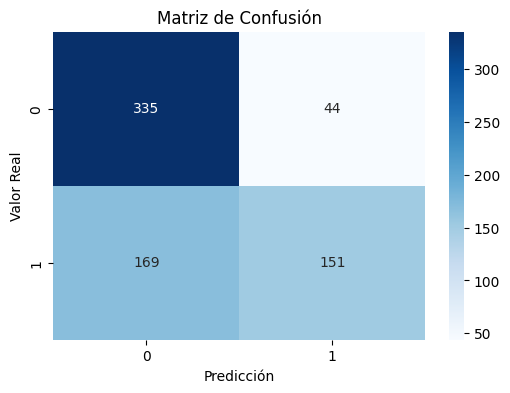

In [35]:
combinacion([preds_xgb_biomedlm[0], preds_rf_biomedlm[0], preds_lr_bioclinical[0], preds_svm_tfidf[0]], y_test=y_val) # votacion mayoritaria

Accuracy: 0.7268

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       379
           1       0.72      0.65      0.69       320

    accuracy                           0.73       699
   macro avg       0.73      0.72      0.72       699
weighted avg       0.73      0.73      0.73       699



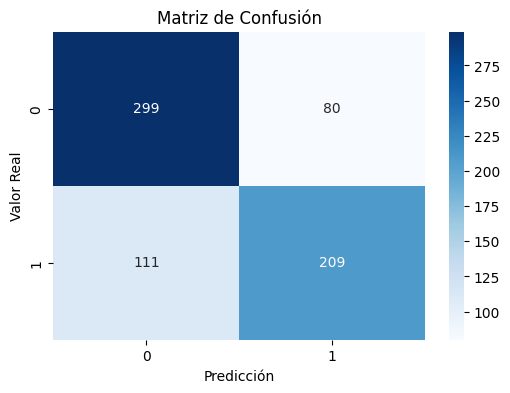

In [36]:
combinacion([preds_xgb_biomedlm[1], preds_rf_biomedlm[1], preds_lr_bioclinical[1], preds_lr_tfidf[1]], y_test=y_val, tipo='promedio') # promedio simple

Otras combinaciones con precisión similar:
(0.7339055793991416, (0.7, 1.3))
(0.7396280400572246, (0.8, 1.2))
Pesos del mejor modelo combinado: (0.8, 1.2). Accuracy: 0.7396

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       379
           1       0.73      0.69      0.71       320

    accuracy                           0.74       699
   macro avg       0.74      0.74      0.74       699
weighted avg       0.74      0.74      0.74       699



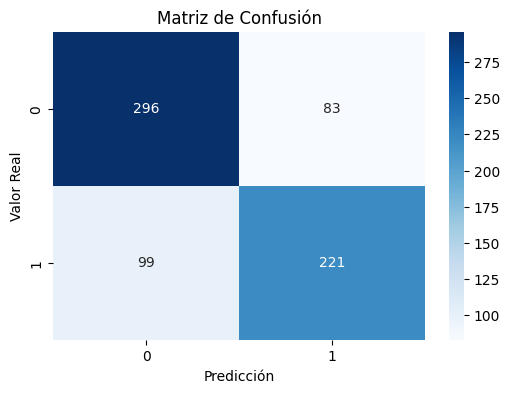

In [34]:
best_weights = combinacion([preds_rf_biomedlm[1], preds_lr_bioclinical[1]], y_test=y_val, tipo='find_promedio') # encontrar mejores pesos

En un principio, no se intentó combinar las predicciones de los modelos de clasificación con la vectorización TF-IDF, ya que se consideró que los *embeddings* de los modelos de lenguaje deberían ser suficientes para obtener una buena precisión. Se quiso comprobar la precisión de los modelos por separado antes de intentar combinarlos, para poder evaluar si la combinación de los mismos aporta una mejora significativa.

### Predicciones con conjunto de *test*

Una vez que hemos evaluado los modelos de clasificación, haremos predicciones sobre el conjunto de *test*. No se profundizará tanto en el código ya que gran parte es reutilizado y, por tanto, ya explicado.

In [8]:
df_new = pd.read_csv('/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/ficheros necesarios/test_data_with_no_correctness_label.csv', sep=' ')
df_new = get_topics_from_xml(df_new, xml_file)
df_new['cleaned_passage'] = df_new['passage'].apply(clean_text)
df_new.to_csv('df_new.csv', index=False)
df_new

,topic,topic_text,docId,passage,cleaned_passage
0,27,Can turmeric treat COVID-19?,0b60ca08-1e29-4286-9a52-bf70e51a3307,Coronavirus: Public can pose health questions ...,coronavirus public pose health question volunt...
1,27,Can turmeric treat COVID-19?,0bdd4e10-116d-4c20-abec-730ac1b57aa2,Coronavirus outbreak: Supreme Court's Offices ...,coronavirus outbreak supreme court office regi...
2,27,Can turmeric treat COVID-19?,13b2be2c-ab67-4de1-a456-a7c57f29911b,"COVID-19: Food that relieves symptoms, dietiti...",covid food relieve symptom dietitian review va...
3,27,Can turmeric treat COVID-19?,1f310f69-6e80-4158-94e8-17d5367f92ca,The myths and misinformation revolving around ...,myth misinformation revolve coronavirus outbre...
4,27,Can turmeric treat COVID-19?,2243553b-3ef2-45cc-8003-b4064bf7e013,TURMERIC – THE WONDER SPICE – Kaieteur News La...,turmeric wonder spice kaieteur news late updat...
...,...,...,...,...,...
1349,50,Can drinking lemon water prevent COVID-19?,f60da83f-3162-460f-a35c-18eb1dc610e5,Cameroon's Coronavirus Cases Jump To 223 - Bre...,cameroon coronavirus case jump breaking time b...
1350,50,Can drinking lemon water prevent COVID-19?,f9a8c646-a14a-46fd-81a6-7cacbba07a54,Fact Check: Did BMC appeal to all citizens to ...,fact check bmc appeal citizen drink boil water...
1351,50,Can drinking lemon water prevent COVID-19?,fa9fd78d-8160-441f-acda-92365cdad997,AP NOT REAL NEWS: False coronavirus claims and...,ap real news false coronavirus claim phony rem...
1352,50,Can drinking lemon water prevent COVID-19?,fc7d8362-114f-4536-a51f-07275536558a,FACT CHECK: Viral Image Claims No Israelis Hav...,fact check viral image claim israelis die covi...


Primero debemos tokenizar los pasajes del conjunto de *test* y obtener sus *embeddings*, al igual que hicimos con el conjunto de entrenamiento. Para ello, simplemente aplicamos la función `exec_process` sobre el DataFrame que contiene los pasajes del conjunto de *test*.

In [9]:
data_embeddings_new = exec_process(df_new, filename='embeddingsTest')

100%|██████████| 1354/1354 [03:26<00:00,  6.56it/s]


Del mismo modo que con el conjunto de *test*, leemos el archivo donde están contenidos nuestros *embeddings*, nos aseguramos de que cada elemento de las columnas sea un array de NumPy y vectorizamos los pasajes con el mismo vectorizador que usamos para el conjunto de entrenamiento. Seleccionamos los predictores a usar en nuestro conjunto de *test*, es decir, las correspondientes columnas de *embeddings* y la matriz TF-IDF *sparse* de los nuevos datos.

In [38]:
ruta_embeddings_new = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/embeddingsTest.csv'
data_embeddings_new = pd.read_csv(ruta_embeddings_new)

# modelo biomedlm
X_biomedlm_prueba = np.array(data_embeddings_new['biomed_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo bioclinicalbert
X_bioclinical_prueba = np.array(data_embeddings_new['bioclinicalbert_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo tfidf (convertimos matriz sparse a matriz densa)
X_tfidf_prueba = vectorizer.transform(data_embeddings_new['cleaned_passage']).toarray()

Cargamos los modelos de clasificación ya entrenados que queremos usar para hacer las predicciones. Para la primera entrega probaremos con los mejores modelos evaluados: *Random Forest*, *Support Vector Machine* y *XGBoost* que hicieron uso de la vectorización TF-IDF, y combinaciones de la regresión logística con los *embeddings* de Bio_ClinicalBERT y el *Random Forest* con los *embeddings* de BioMedLM.

In [41]:
modelo_rf_biomedlm = cargar_modelo('RandomForestClassifier_biomedlm_entrenado.pkl', 'modelo_rf_biomedlm')
modelo_lr_bioclinical = cargar_modelo('LogisticRegression_bioclinical_entrenado.pkl', 'modelo_lr_bioclinical')
modelo_svm_tfidf = cargar_modelo('SVC_tfidf_entrenado.pkl', 'modelo_svm_tfidf')
modelo_rf_tfidf = cargar_modelo('RandomForestClassifier_tfidf_entrenado.pkl', 'modelo_rf_tfidf')
modelo_xgb_tfidf = cargar_modelo('XGBClassifier_tfidf_entrenado.pkl', 'modelo_xgb_tfidf')

# predicciones
preds_prueba_rf_biomedlm = predicciones(X_biomedlm_prueba, modelo_rf_biomedlm, data=df_new, filename='predicciones_rf_biomedlm')
preds_prueba_lr_bioclinical = predicciones(X_bioclinical_prueba, modelo_lr_bioclinical, data=df_new, filename='predicciones_lr_bioclinical')
preds_prueba_svm_tfidf = predicciones(X_tfidf_prueba, modelo_svm_tfidf, data=data_embeddings_new, filename='predicciones_svm_tfidf')
preds_prueba_rf_tfidf = predicciones(X_tfidf_prueba, modelo_rf_tfidf, data=data_embeddings_new, filename='predicciones_rf_tfidf')
preds_prueba_xgb_tfidf = predicciones(X_tfidf_prueba, modelo_xgb_tfidf, data=data_embeddings_new, filename='predicciones_xgb_tfidf')

Obtenemos las predicciones resultado de combinar `preds_prueba_rf_biomedlm` y `preds_prueba_lr_bioclinical`, usando los mejores pesos obtenidos en la evaluación de la combinación de estos dos modelos. Recordemos que ahora no podemos hallar el mejor promedio, pero si podemos usar los pesos obtenidos como "mejores" en el parámetro `w` de la función `combinacion`.

In [ ]:
combinacion([preds_prueba_rf_biomedlm[1], preds_prueba_lr_bioclinical[1]], w=list(best_weights), save=[df_new, 'rf_biomed_lr_bioclinical'], tipo='promedio') # promedio pesado

### Segunda aproximación (2024-12-05)

Ya abordamos el problema de tratar los pasajes de más de 512 tokens: el proceso complicó en gran medida la complejidad del codigo, al tener que dividir en *chunks* cada pasaje, obtener los *embeddings* del mismo y luego concatenar los *embeddings* de cada bloque del pasaje original para obtener una represetnación única del mismo. Esto, a pesar de usar una capa de atención muy sencilla, complico en gran medida el proceso. Del mismo modo, hacer el fine tuning considerando los pasajes que exceden los 512 tokens complica en gran medida la tarea, al tener que redefinir funciones y estructuras de datos para poder procesar los pasajes de forma adecuada. 

Por ello, vamos a intentar abordar el problema de otra forma. Intentaremos resumir los pasajes usando el modelo [base de T5](). Además, también probaremos con un GridSearch de los modelos de clasificación usados y un finetuning del modelo Bio_ClinicalBERT.

**Nota.** Muchas de las funciones aquí usadas ya han sido explicadas con anterioridad. Aquí simplemente se pretende modificar ligeramente los *inputs* o la capa final de clasificación, por lo que se reusa gran parte del código cambiando simplemente los parámetros. Por este motivo, las explicaciones serán más concisas.

**1. Resumen con T5**

Para resumir los pasajes, acudimos a la tabla con los pasajes ya preprocesados (limpieza del texto).

In [10]:
ruta_tabla = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/df.csv'
df2 = pd.read_csv(ruta_tabla)
df2

,topic,topic_text,docId,correctness,passage,cleaned_passage
0,1,Can vitamin D cure COVID-19?,0113bb03-2a3a-4602-9394-d2fe911b624a,0,Tyler Perry Reveals Role Vitamin D Plays In Fi...,tyler perry reveal role vitamin d play fight c...
1,1,Can vitamin D cure COVID-19?,015c98bf-8632-4537-9038-7bc3e128cb97,0,This is why you should include Vitamin C and Z...,include vitamin c zinc daily diet orissapost h...
2,1,Can vitamin D cure COVID-19?,01e198e3-ec00-432d-92f0-cca8251db33d,0,Supplements for Coronavirus Probably Won’t Hel...,supplement coronavirus probably will not help ...
3,1,Can vitamin D cure COVID-19?,02700110-5195-4cee-b584-8fe6d870e2dd,0,Coronavirus: Top ways to protect yourself from...,coronavirus way protect vaccine develop mirror...
4,1,Can vitamin D cure COVID-19?,02fb6095-115b-4418-bb34-8b76cc65059c,0,Coronavirus: It’s Time to Debunk Claims That V...,coronavirus time debunk claim vitamin c cure m...
...,...,...,...,...,...,...
3490,25,Can high temperatures and humidity prevent COV...,fade068e-5598-4a5b-b194-fb90885c84a2,0,Would COVID-19 end in summer?: The DONG-A ILBO...,covid end summer donga ilbo content pdf voda n...
3491,25,Can high temperatures and humidity prevent COV...,fb6a1e79-37cf-4cbd-ad3f-48fa25dcf9ab,1,Coronavirus MORE POWERFUL than first thought a...,coronavirus powerful thought terrify superspre...
3492,25,Can high temperatures and humidity prevent COV...,fe95c08a-a416-44e9-b564-612daff46542,0,Good News: Chinese Scientists have Proven that...,good news chinese scientist prove warm weather...
3493,25,Can high temperatures and humidity prevent COV...,fef130d2-df1f-480b-9d0f-d34c6b247ab6,0,Don't Count on Warmer Weather to Curb COVID-19...,not count warm weather curb covid skip main co...


Buscamos hacer un resumen de cada pasaje basado en la pregunta. Para ello, debemos concatenar la pregunta con el contexto (el pasaje en cuestión). De este modo, el modelo T5 será capaz de dar un resumen del mismo. Fijaremos la longitud máxima del resumen en 500 *tokens*, lo que permitirá evitar el uso de *chunks* al calcular las representaciones de *embeddings* o hacer el *finetuning* del modelo tipo BERT que estamos usando. 

T5 admite entradas de más de 512 *tokens* sin necesidad de truncar y, cómo buscamos un resumen general, fijamos `truncation=False`. En caso de truncar, deberiamos dividir un pasaje en *chunks*, resumir cada uno y luego combinarlos de alguna forma, como con una capa de atención. Esta opción podría dar resúmenes con una menor cohesión al no tener el contexto global del pasaje a la hora de resumir, por lo que no se considera. Además, T5 es un modelo con *encoder* y *decoder*, por lo que antes de darle el texto de entrada es necesario tokenizarlo (`input_ids`), y a la salida es necesario hacerle un *decoding* en la variable `output`. 

Todo este proceso de resumen se hace en la función `summarize`, que toma como argumentos la pregunta y el pasaje, así com oel modelo y el tokenizador, que se fijan por defecto según los del modelo base de T5.

Por último, definimos una función que aplique esta última al DataFrame, `summarize_row`. Esta simplemente coge una fila del DataFrame, extrae la pregunta y el pasaje, lo pasa por la función `summarize` y devuelve el resumen (`summary`).

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# tokenizador y  modelo T5
tokenizer_T5 = T5Tokenizer.from_pretrained('t5-base')
modelo_T5 = T5ForConditionalGeneration.from_pretrained('t5-base')

def summarize(question, passage, model=modelo_T5, tokenizer=tokenizer_T5, max_length=500):
    # combinamos la pregunta y el pasaje
    input_text = f"summarize: question: {question} context: {passage}"
    # tokenizar el texto de entrada, sin truncar
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=None, truncation=False)
    # generamos un resumen de menos de 500 tokens
    summary_ids = model.generate(input_ids, max_length=max_length, min_length=100, 
                                 length_penalty=1.5, num_beams=4, early_stopping=True, 
                                 no_repeat_ngram_size=2)
    # decoding del resumen
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output

def summarize_row(row, resumen=summarize):
    question = row['topic_text']
    passage = row['cleaned_passage']
    summary = resumen(question, passage)
    return summary

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Aquí simplemente usamos la función `summarize_row` sobre el DataFrame con la función `progress_apply`, que nos da también una barra de progreso. Además, definimos una columna con la longitud de los pasajes tras haber sido resumidos y lo guardamos en un nuevo archivo `.csv`, para poder acceder a esta información con facilidad.

In [ ]:
tqdm.pandas()

# longitud de los pasajes antes del resumen
df2['token_length'] = df2['cleaned_passage'].apply(lambda x: len(tokenizer_T5.tokenize(x)))

# resumimos y lo guardamos en el DataFrame
df2['cleaned_passage'] = df2.progress_apply(summarize_row, axis=1)

# longitud de los pasajes despues del resumen
df2['token_length'] = df2['cleaned_passage'].apply(lambda x: len(tokenizer_T5.tokenize(x)))

df2.to_csv(f'cleanT5.csv', index=False)

100%|██████████| 3495/3495 [9:02:12<00:00,  9.31s/it]  


**1.1. Representaciones de embeddings**

Ahora seguimos un proceso análogo al realizado anteriormente para tokenizar usando los modelos BioMedLM y Bio_ClinicalBERT. Definimos los modelos y tokenizadores a usar, junto a las capas de atención de cada uno:

In [13]:
biomed_model = AutoModelForCausalLM.from_pretrained("stanford-crfm/BioMedLM")
bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2)

attention_layer_biomed = Attention(embed_dim=embed_dim_biomed)
attention_layer_bert = Attention(embed_dim=embed_dim_bert)

biomed_tokenizer = AutoTokenizer.from_pretrained("stanford-crfm/BioMedLM")
bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

Y procedemos a calcular las representaciones de *embeddings* que da cada modelo, ahora usando los pasajes resumidos por T5. Esto lo guardamos en `embeddingsResumen.csv`

In [14]:
data_embeddingsResumen = exec_process(df2, modelos=[(biomed_model, 'biomedlm'), (bert_model, 'bioclinicalbert')], tokenizadores=[biomed_tokenizer, bert_tokenizer], attention_layers=[attention_layer_biomed, attention_layer_bert], filename='embeddingsResumen')

100%|██████████| 3495/3495 [02:56<00:00, 19.77it/s]


**1.2. Evaluación de modelos**

Primero haremos una evaluación de los mismos modelos de clasificación usados antes (con los mismos hiperparámetros). Esto nos permitirá ver la diferencia entre usar o no los pasajes resumidos, y ver que opción resulta más precisa a la hora de categorizar. 

Cargamos los nuevos datos de *embeddings*:

In [54]:
ruta_embeddingsResumen = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/embeddingsResumen.csv'
data_embeddingsResumen = pd.read_csv(ruta_embeddingsResumen)

Dividimos el conjunto de datos en conjunto de *train* y de validación (recordemos la importancia de estratificar), y separamos la variable predictora y la dependiente. Es importante reconvertir los *embeddings* extraidos del DataFrame a arrays de NumPy para poder reutilizar las funciones usadas en la primera aproximación. Además, obtenemos las vectorizaciones TF-IDF de los pasajes resumidos. 

In [55]:
train_dataResumen, val_dataResumen = train_test_split(data_embeddingsResumen, test_size=0.2, random_state=42, stratify=data_embeddingsResumen['correctness'])

# etiquetas
y_trainResumen = train_dataResumen['correctness']
y_valResumen = val_dataResumen['correctness']

# modelo biomedlm
X_biomedlm_trainResumen = np.array(train_dataResumen['biomedlm_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())
X_biomedlm_valResumen = np.array(val_dataResumen['biomedlm_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo bioclinicalbert
X_bioclinical_trainResumen = np.array(train_dataResumen['bioclinicalbert_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())
X_bioclinical_valResumen = np.array(val_dataResumen['bioclinicalbert_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo tfidf (convertimos matriz sparse a matriz densa)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf_trainResumen = vectorizer.fit_transform(train_dataResumen['cleaned_passage']).toarray()
X_tfidf_valResumen = vectorizer.transform(val_dataResumen['cleaned_passage']).toarray()

Hacemos una verificación del tipo y dimensión de los datos, para evitar errores en la ejecución

In [56]:
print(type(X_biomedlm_trainResumen), X_biomedlm_trainResumen.shape)
print(type(X_bioclinical_trainResumen), X_bioclinical_trainResumen.shape)
print(type(X_tfidf_trainResumen), X_tfidf_trainResumen.shape)

print(type(X_biomedlm_valResumen), X_biomedlm_valResumen.shape)
print(type(X_bioclinical_valResumen), X_bioclinical_valResumen.shape)
print(type(X_tfidf_valResumen), X_tfidf_valResumen.shape)

<class 'numpy.ndarray'> (2796, 2560)
<class 'numpy.ndarray'> (2796, 768)
<class 'numpy.ndarray'> (2796, 5000)
<class 'numpy.ndarray'> (699, 2560)
<class 'numpy.ndarray'> (699, 768)
<class 'numpy.ndarray'> (699, 5000)


Ahora, pasamos estas representaciones numéricas de los pasajes resumidos a los mismos modelos que se usaron en la primera aproximación (mismos hiperparámetros, pero se entrena un modelo distinto con los nuevos datos), es decir, Regresión Logística, *Random Forest*, *XGBoost* y *Support Vector Machine*. Esto permitirá comparar el rendimiento de los mismos al entrenar con pasajes resumidos o completos.

In [66]:
modelo_lr_biomedlmResumen = modeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='lr', data_type='biomedlm_resumen')
modelo_lr_bioclinicalResumen = modeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='lr', data_type='bioclinical_resumen')
modelo_lr_tfidfResumen = modeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='lr', data_type='tfidf_resumen')

modelo_svm_biomedlmResumen = modeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='svm', data_type='biomedlm_resumen')
modelo_svm_bioclinicalResumen = modeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='svm', data_type='bioclinical_resumen')
modelo_svm_tfidfResumen = modeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='svm', data_type='tfidf_resumen')

modelo_rf_biomedlmResumen = modeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='rf', data_type='biomedlm_resumen')
modelo_rf_bioclinicalResumen = modeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='rf', data_type='bioclinical_resumen')
modelo_rf_tfidfResumen = modeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='rf', data_type='tfidf_resumen')

modelo_xgb_biomedlmResumen = modeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='xgb', data_type='biomedlm_resumen')
modelo_xgb_bioclinicalResumen = modeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='xgb', data_type='bioclinical_resumen')
modelo_xgb_tfidfResumen = modeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='xgb', data_type='tfidf_resumen')


Ahora, pasamos con la evalución de los modelos. Esta se hará de la misma forma que antes, cargamos el modelo entrenado (si no estuviera ya cargado) y hacemos predicciones sobre los datos de validación, dando la *accuracy*, el reporte de clasificación y una matriz de confusión.

**1.2.1. BioMedLm**

Modelo LogisticRegression
Accuracy: 0.5622

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       379
           1       0.52      0.50      0.51       320

    accuracy                           0.56       699
   macro avg       0.56      0.56      0.56       699
weighted avg       0.56      0.56      0.56       699



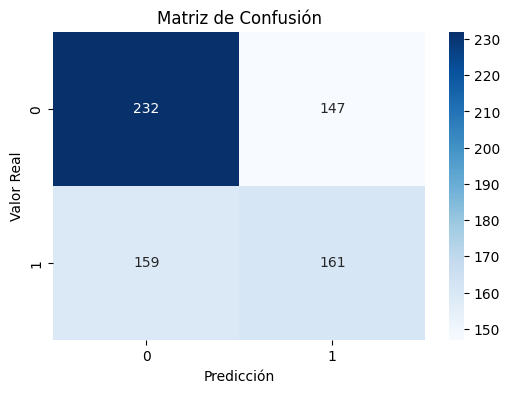

Modelo RandomForestClassifier
Accuracy: 0.5722

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       379
           1       0.54      0.50      0.52       320

    accuracy                           0.57       699
   macro avg       0.57      0.57      0.57       699
weighted avg       0.57      0.57      0.57       699



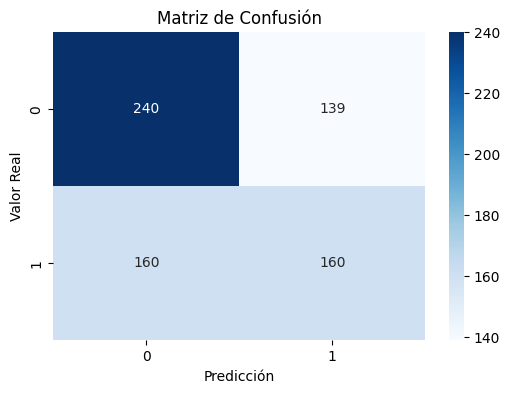

Modelo XGBClassifier
Accuracy: 0.5880

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       379
           1       0.55      0.52      0.53       320

    accuracy                           0.59       699
   macro avg       0.58      0.58      0.58       699
weighted avg       0.59      0.59      0.59       699



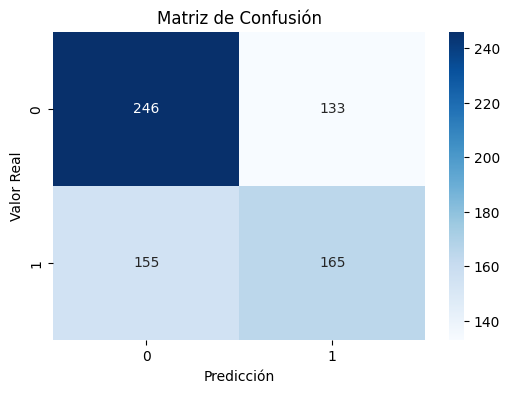

Modelo SVC
Accuracy: 0.5665

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       379
           1       0.53      0.49      0.51       320

    accuracy                           0.57       699
   macro avg       0.56      0.56      0.56       699
weighted avg       0.56      0.57      0.57       699



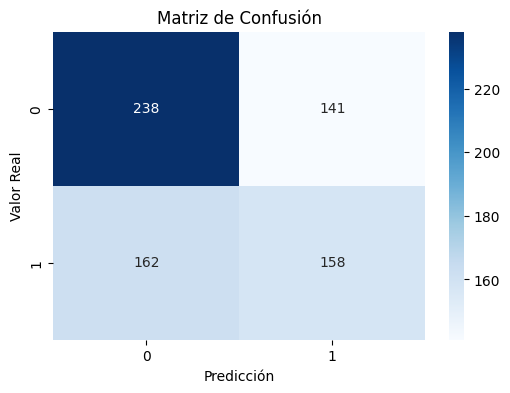

In [ ]:
modelo_lr_biomedlmResumen = cargar_modelo('LogisticRegression_biomedlm_resumen_entrenado.pkl', 'modelo_lr_biomedlmResumen')
modelo_rf_biomedlmResumen = cargar_modelo('RandomForestClassifier_biomedlm_resumen_entrenado.pkl', 'modelo_rf_biomedlmResumen')
modelo_xgb_biomedlmResumen = cargar_modelo('XGBClassifier_biomedlm_resumen_entrenado.pkl', 'modelo_xgb_biomedlmResumen')
modelo_svm_biomedlmResumen = cargar_modelo('SVC_biomedlm_resumen_entrenado.pkl', 'modelo_svm_biomedlmResumen')

# predicciones
preds_lr_biomedlmResumen = predicciones(X_biomedlm_valResumen, modelo_lr_biomedlmResumen, y=y_valResumen)
preds_rf_biomedlmResumen = predicciones(X_biomedlm_valResumen, modelo_rf_biomedlmResumen, y=y_valResumen)
preds_xgb_biomedlmResumen = predicciones(X_biomedlm_valResumen, modelo_xgb_biomedlmResumen, y=y_valResumen)
preds_svm_biomedlmResumen = predicciones(X_biomedlm_valResumen, modelo_svm_biomedlmResumen, y=y_valResumen)

**1.2.2. Bio_ClinicalBERT**

Modelo LogisticRegression
Accuracy: 0.6352

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       379
           1       0.60      0.60      0.60       320

    accuracy                           0.64       699
   macro avg       0.63      0.63      0.63       699
weighted avg       0.63      0.64      0.64       699



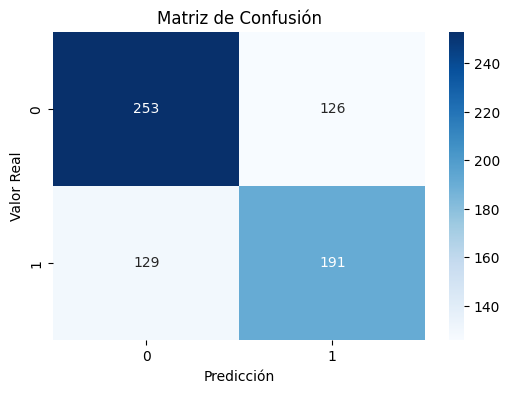

Modelo RandomForestClassifier
Accuracy: 0.6252

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.62      0.79      0.69       379
           1       0.63      0.43      0.51       320

    accuracy                           0.63       699
   macro avg       0.63      0.61      0.60       699
weighted avg       0.63      0.63      0.61       699



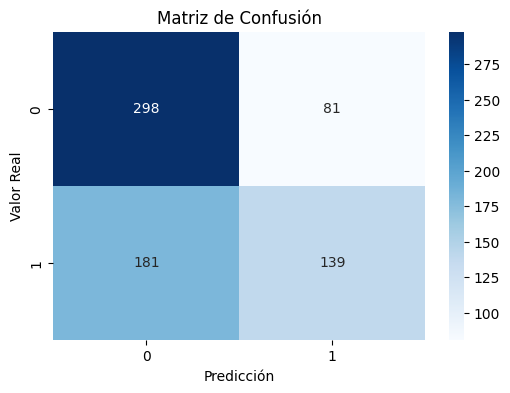

Modelo XGBClassifier
Accuracy: 0.6309

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       379
           1       0.60      0.56      0.58       320

    accuracy                           0.63       699
   macro avg       0.63      0.63      0.63       699
weighted avg       0.63      0.63      0.63       699



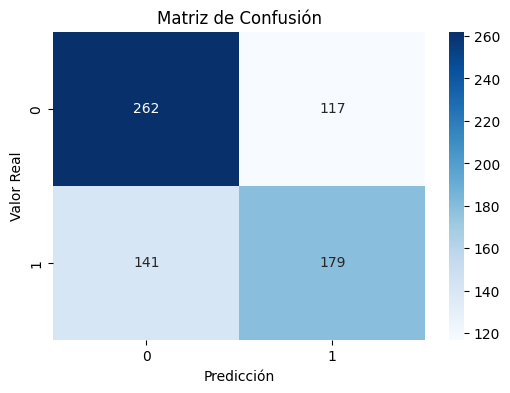

Modelo SVC
Accuracy: 0.6209

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       379
           1       0.59      0.59      0.59       320

    accuracy                           0.62       699
   macro avg       0.62      0.62      0.62       699
weighted avg       0.62      0.62      0.62       699



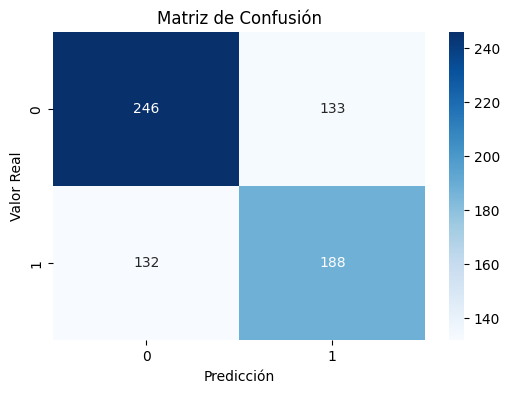

In [77]:
modelo_lr_bioclinicalResumen = cargar_modelo('LogisticRegression_bioclinical_resumen_entrenado.pkl', 'modelo_lr_bioclinicalResumen')
modelo_rf_bioclinicalResumen = cargar_modelo('RandomForestClassifier_bioclinical_resumen_entrenado.pkl', 'modelo_rf_bioclinicalResumen')
modelo_xgb_bioclinicalResumen = cargar_modelo('XGBClassifier_bioclinical_resumen_entrenado.pkl', 'modelo_xgb_bioclinicalResumen')
modelo_svm_bioclinicalResumen = cargar_modelo('SVC_bioclinical_resumen_entrenado.pkl', 'modelo_svm_bioclinicalResumen')

# predicciones
preds_lr_bioclinicalResumen = predicciones(X_bioclinical_valResumen, modelo_lr_bioclinicalResumen, y=y_valResumen)
preds_rf_bioclinicalResumen = predicciones(X_bioclinical_valResumen, modelo_rf_bioclinicalResumen, y=y_valResumen)
preds_xgb_bioclinicalResumen = predicciones(X_bioclinical_valResumen, modelo_xgb_bioclinicalResumen, y=y_valResumen)
preds_svm_bioclinicalResumen = predicciones(X_bioclinical_valResumen, modelo_svm_bioclinicalResumen, y=y_valResumen)

**1.2.3. TF-IDF**

Modelo LogisticRegression
Accuracy: 0.7511

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       379
           1       0.76      0.68      0.71       320

    accuracy                           0.75       699
   macro avg       0.75      0.75      0.75       699
weighted avg       0.75      0.75      0.75       699



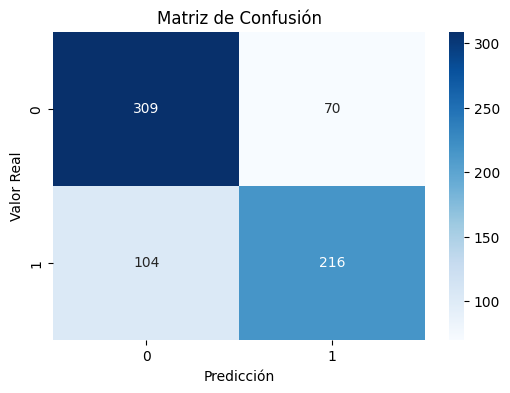

Modelo RandomForestClassifier
Accuracy: 0.7611

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       379
           1       0.75      0.71      0.73       320

    accuracy                           0.76       699
   macro avg       0.76      0.76      0.76       699
weighted avg       0.76      0.76      0.76       699



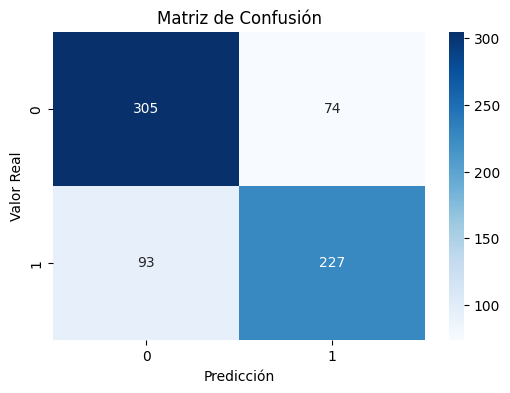

Modelo XGBClassifier
Accuracy: 0.7239

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       379
           1       0.71      0.68      0.69       320

    accuracy                           0.72       699
   macro avg       0.72      0.72      0.72       699
weighted avg       0.72      0.72      0.72       699



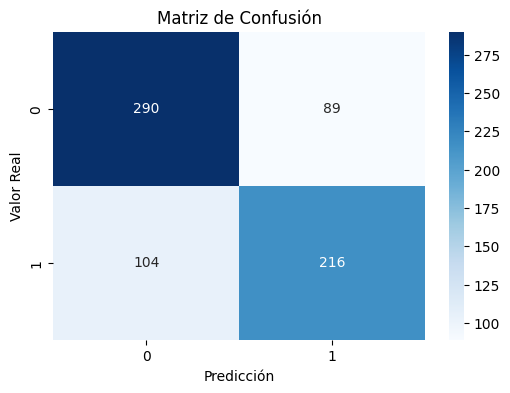

Modelo SVC
Accuracy: 0.7568

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       379
           1       0.75      0.71      0.73       320

    accuracy                           0.76       699
   macro avg       0.76      0.75      0.75       699
weighted avg       0.76      0.76      0.76       699



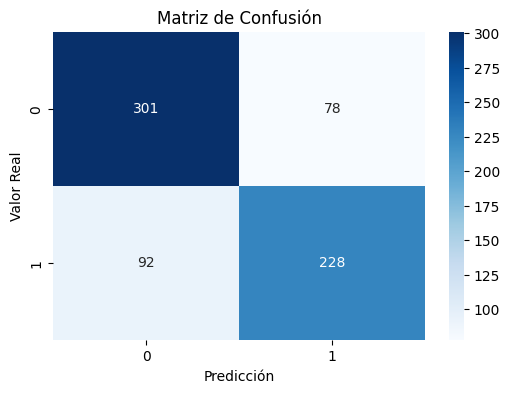

In [78]:
modelo_lr_tfidfResumen = cargar_modelo('LogisticRegression_tfidf_resumen_entrenado.pkl', 'modelo_lr_tfidfResumen')
modelo_rf_tfidfResumen = cargar_modelo('RandomForestClassifier_tfidf_resumen_entrenado.pkl', 'modelo_rf_tfidfResumen')
modelo_xgb_tfidfResumen = cargar_modelo('XGBClassifier_tfidf_resumen_entrenado.pkl', 'modelo_xgb_tfidfResumen')
modelo_svm_tfidfResumen = cargar_modelo('SVC_tfidf_resumen_entrenado.pkl', 'modelo_svm_tfidfResumen')

# predicciones
preds_lr_tfidfResumen = predicciones(X_tfidf_valResumen, modelo_lr_tfidfResumen, y=y_valResumen)
preds_rf_tfidfResumen = predicciones(X_tfidf_valResumen, modelo_rf_tfidfResumen, y=y_valResumen)
preds_xgb_tfidfResumen = predicciones(X_tfidf_valResumen, modelo_xgb_tfidfResumen, y=y_valResumen)
preds_svm_tfidfResumen = predicciones(X_tfidf_valResumen, modelo_svm_tfidfResumen, y=y_valResumen)

Vemos que, en general, los resultados son considerablemente peores que cuando usábamos las representaciones numéricas de los pasajes completos. En el caso de usar TF-IDF, esta reducción en el *accuracy*, pese a existir, es menos apreciable.

**1.2.4. Combinaciones**

Accuracy: 0.7124

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       379
           1       0.71      0.64      0.67       320

    accuracy                           0.71       699
   macro avg       0.71      0.71      0.71       699
weighted avg       0.71      0.71      0.71       699



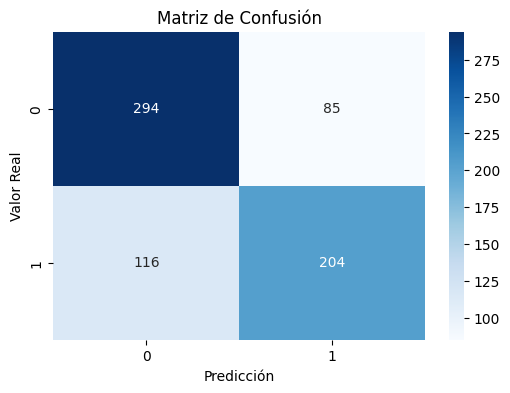

In [79]:
combinacion([preds_xgb_biomedlmResumen[0], preds_lr_bioclinicalResumen[0], preds_rf_tfidfResumen[0]], y_test=y_valResumen) # votacion mayoritaria

Accuracy: 0.6881

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       379
           1       0.67      0.62      0.65       320

    accuracy                           0.69       699
   macro avg       0.69      0.68      0.68       699
weighted avg       0.69      0.69      0.69       699



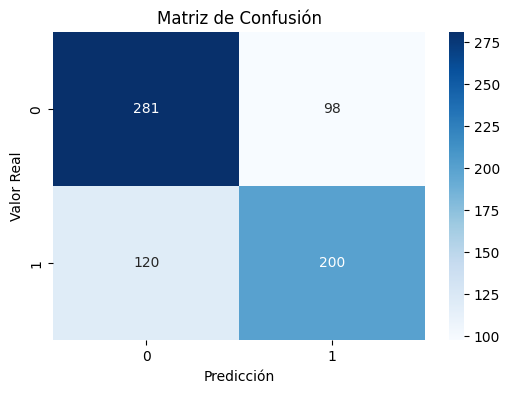

In [80]:
combinacion([preds_xgb_biomedlmResumen[1], preds_lr_bioclinicalResumen[1], preds_rf_tfidfResumen[1]], y_test=y_valResumen, tipo='promedio') # promedio simple

Otras combinaciones con precisión similar:
(0.7625178826895566, (0.6, 0.2, 1.3, 1.9))
(0.7639484978540773, (0.5, 0.5, 0.8, 2.2))
(0.7610872675250357, (0.6, 0.2, 1.2, 2.0))
(0.7668097281831188, (0.4, 0.5, 1.1, 2.0))
(0.765379113018598, (0.5, 0.5, 0.9, 2.1))
(0.7682403433476395, (0.4, 0.5, 1.0, 2.1))
(0.7696709585121603, (0.0, 0.6, 2.3, 1.1))
Pesos del mejor modelo combinado: (0.0, 0.6, 2.3, 1.1). Accuracy: 0.7697

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       379
           1       0.77      0.71      0.74       320

    accuracy                           0.77       699
   macro avg       0.77      0.76      0.77       699
weighted avg       0.77      0.77      0.77       699



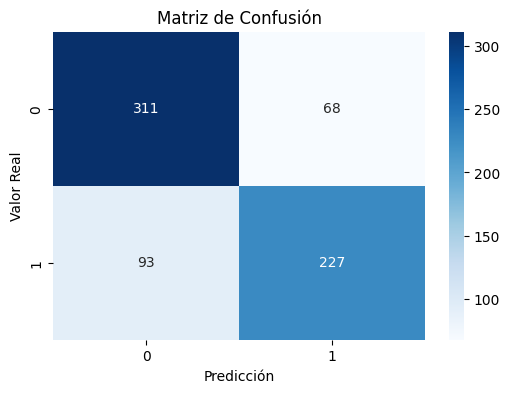

In [86]:
best_weightsResumen = combinacion([preds_xgb_biomedlmResumen[1], preds_lr_bioclinicalResumen[1], preds_rf_tfidfResumen[1], preds_svm_tfidfResumen[1]], y_test=y_valResumen, tipo='find_promedio') # encontrar mejores pesos

La creación de *ensembles* mediante combinaciones de los modelos anteriores, sin embargo, lleva a resultados similares en ambos casos. Concretamente, destacamos la última combinación, con un *accuracy* del 77%. 

**1.3. Predicciones sobre datos de *test***

Usaremos este *ensemble* para sacar predicciones con los datos de *test*. Primero, obtenemos los datos de *test*

In [15]:
ruta_tablaTest = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/df_new.csv'
df_testResumen = pd.read_csv(ruta_tablaTest)
df_testResumen

,topic,topic_text,docId,passage,cleaned_passage
0,27,Can turmeric treat COVID-19?,0b60ca08-1e29-4286-9a52-bf70e51a3307,Coronavirus: Public can pose health questions ...,coronavirus public pose health question volunt...
1,27,Can turmeric treat COVID-19?,0bdd4e10-116d-4c20-abec-730ac1b57aa2,Coronavirus outbreak: Supreme Court's Offices ...,coronavirus outbreak supreme court office regi...
2,27,Can turmeric treat COVID-19?,13b2be2c-ab67-4de1-a456-a7c57f29911b,"COVID-19: Food that relieves symptoms, dietiti...",covid food relieve symptom dietitian review va...
3,27,Can turmeric treat COVID-19?,1f310f69-6e80-4158-94e8-17d5367f92ca,The myths and misinformation revolving around ...,myth misinformation revolve coronavirus outbre...
4,27,Can turmeric treat COVID-19?,2243553b-3ef2-45cc-8003-b4064bf7e013,TURMERIC – THE WONDER SPICE – Kaieteur News La...,turmeric wonder spice kaieteur news late updat...
...,...,...,...,...,...
1349,50,Can drinking lemon water prevent COVID-19?,f60da83f-3162-460f-a35c-18eb1dc610e5,Cameroon's Coronavirus Cases Jump To 223 - Bre...,cameroon coronavirus case jump breaking time b...
1350,50,Can drinking lemon water prevent COVID-19?,f9a8c646-a14a-46fd-81a6-7cacbba07a54,Fact Check: Did BMC appeal to all citizens to ...,fact check bmc appeal citizen drink boil water...
1351,50,Can drinking lemon water prevent COVID-19?,fa9fd78d-8160-441f-acda-92365cdad997,AP NOT REAL NEWS: False coronavirus claims and...,ap real news false coronavirus claim phony rem...
1352,50,Can drinking lemon water prevent COVID-19?,fc7d8362-114f-4536-a51f-07275536558a,FACT CHECK: Viral Image Claims No Israelis Hav...,fact check viral image claim israelis die covi...


**1.3.1. Resumen de pasajes de *test***

A continuación, pasamos estos pasajes (ya "limpios") por el modelo T5 para resumirlos, del mismo modo que hicimos con los de *train*.

In [16]:
# tokenizador y  modelo T5
tokenizer_T5 = T5Tokenizer.from_pretrained('t5-base')
modelo_T5 = T5ForConditionalGeneration.from_pretrained('t5-base')

tqdm.pandas()

# longitud de los pasajes antes del resumen
df_testResumen['token_length'] = df_testResumen['cleaned_passage'].apply(lambda x: len(tokenizer_T5.tokenize(x)))

# resumimos y lo guardamos en el DataFrame
df_testResumen['cleaned_passage'] = df_testResumen.progress_apply(summarize_row, axis=1)

# longitud de los pasajes despues del resumen
df_testResumen['token_length'] = df_testResumen['cleaned_passage'].apply(lambda x: len(tokenizer_T5.tokenize(x)))

df_testResumen.to_csv(f'cleanT5_test.csv', index=False)

100%|██████████| 1354/1354 [3:36:38<00:00,  9.60s/it]  


Posteriormente obtenemos las representaciones de *embeddings* de estos nuevos pasajes resumidos, haciendo uso de los mismos dos modelos de lenguaje. Esto lo guardamos en `embeddingsResumen_test.csv`

In [17]:
data_embeddingsResumen_test = exec_process(df_testResumen, modelos=[(biomed_model, 'biomedlm'), (bert_model, 'bioclinicalbert')], tokenizadores=[biomed_tokenizer, bert_tokenizer], attention_layers=[attention_layer_biomed, attention_layer_bert], filename='embeddingsResumen_test')

100%|██████████| 1354/1354 [01:16<00:00, 17.77it/s]


**1.3.2. Predicciones sobre modelos**

Cargamos los datos de las representaciones numéricas de los pasajes de *test*

In [84]:
ruta_embeddingsResumen_test = '/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/Practica/Reto/embeddingsResumen_test.csv'
data_embeddingsResumen_test = pd.read_csv(ruta_embeddingsResumen_test, sep=',')

Convertimos las columnas correspondientes a estas representaciones de *embeddings* al formato adecuado, y vectorizamos los pasajes resumidos con TF-IDF (usando el mismo vectorizador que sobre el conjunto de *train*). 

In [87]:
# modelo biomedlm
X_biomedlm_testResumen = np.array(data_embeddingsResumen_test['biomedlm_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo bioclinicalbert
X_bioclinical_testResumen = np.array(data_embeddingsResumen_test['bioclinicalbert_embeddings'].apply(lambda x: np.squeeze(np.array(ast.literal_eval(x)))).tolist())

# modelo tfidf (convertimos matriz sparse a matriz densa)
X_tfidf_testResumen = vectorizer.transform(data_embeddingsResumen_test['cleaned_passage']).toarray()

Cargamos (si no lo están ya) y hacemos predicciones únicamente los modelos usados para construir el *ensemble* que vimos anteriormente, con un *accuracy* del 77%. 

In [ ]:
modelo_lr_bioclinicalResumen = cargar_modelo('LogisticRegression_bioclinical_resumen_entrenado.pkl', 'modelo_lr_bioclinicalResumen')
modelo_xgb_biomedlmResumen = cargar_modelo('XGBClassifier_biomedlm_resumen_entrenado.pkl', 'modelo_xgb_biomedlmResumen')
modelo_rf_tfidfResumen = cargar_modelo('RandomForestClassifier_tfidf_resumen_entrenado.pkl', 'modelo_rf_tfidfResumen')
modelo_svm_tfidfResumen = cargar_modelo('SVC_tfidf_resumen_entrenado.pkl', 'modelo_svm_tfidfResumen')

# predicciones
preds_xgb_biomedlm_testResumen = predicciones(X_biomedlm_testResumen, modelo_xgb_biomedlmResumen, data=data_embeddingsResumen_test, filename='predicciones_xgb_biomedlm_testResumen')
preds_lr_bioclinical_testResumen = predicciones(X_bioclinical_testResumen, modelo_lr_bioclinicalResumen, data=data_embeddingsResumen_test, filename='predicciones_lr_bioclinical_testResumen')
preds_svm_tfidf_testResumen = predicciones(X_tfidf_testResumen, modelo_svm_tfidfResumen, data=data_embeddingsResumen_test, filename='predicciones_svm_tfidf_testResumen')
preds_rf_tfidf_testResumen = predicciones(X_tfidf_testResumen, modelo_rf_tfidfResumen, data=data_embeddingsResumen_test, filename='predicciones_rf_tfidf_testResumen')

Repetimos la combinación y, usando los mejores pesos encontrados para la misma, `best_weightsResumen`, hacemos las predicciones.

In [ ]:
combinacion([preds_xgb_biomedlm_testResumen[1], preds_lr_bioclinical_testResumen[1], preds_rf_tfidf_testResumen[1], preds_svm_tfidf_testResumen[1]], w=list(best_weightsResumen), save=[data_embeddingsResumen_test, 'xgb_biomedResumen_lr_bioclinicalResumen_rf_svm_tfidfResumen'], tipo='promedio') # promedio pesado

**2. GridSearch**

Visto que ligeras variaciones sobre los *inputs* de los modelos de clasificación no llevan a mejores resultados, haremos una búsqueda de hiperparámetros de los modelos que estamos usando. Sería muy sencillo modificar la función `modeloClasificacion` para que admita una búsqueda de hiperparámetros con validación cruzada. Simplemente habría que incluir algunos parámetros como el *grid* de hiperparámetros sobre el que probar, el número de *folds* a probar, que dejaremos por defecto en 5, y el *scoring* que se quiere, que fijaremos por defecto en `accuracy`. 

El modelo se inicializaría del mismo modo que antes, pero esta vez se pasaría a la función `GridSearchCV`. Luego, con un `.fit` se ajustarían todos los modelos en el rango de hiperparámetros dado por el `grid`. La función debería guardar y devolver el mejor modelo.

Para mantener el flujo temporal del trabajo, no modificaremos la función `modeloClasificacion`, sino que crearemos una nueva función `mejorModeloClasificacion` que implemente las correcciones que comentamos habría que hacer sobre `modeloClasificacion` para que admitiera la búsqueda de hiperparámetros con validación cruzada. Además, añadimos para cada modelo un *grid* de hiperparámetros a probar por defecto. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import os

def mejorModeloClasificacion(x_train, y_train, type_model, data_type, param_grid=None, cv=5, scoring='accuracy', random_state=42):
    assert x_train is not None and y_train is not None, "Datos de entrenamiento no proporcionados"
    assert type_model in ['lr', 'svm', 'rf', 'xgb'], "Modelo no válido"

    # Inicializar modelo base y parámetros por defecto si no se proporcionan
    if type_model == 'lr':
        model = LogisticRegression(random_state=random_state, max_iter=10000)
        if param_grid is None:
            param_grid = {
                'C': [0.01, 0.1, 1, 10],
                'penalty': ['l2'],
                'solver': ['liblinear', 'saga']
            }
    elif type_model == 'svm':
        model = SVC(probability=True, random_state=random_state)
        if param_grid is None:
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
    elif type_model == 'rf':
        model = RandomForestClassifier(random_state=random_state)
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 200, 300],
                'min_samples_leaf': [1, 2, 4]
            }
    elif type_model == 'xgb':
        model = XGBClassifier(eval_metric='logloss', random_state=random_state)
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 200, 300],
                'min_child_weight': [1, 3, 5],
                'learning_rate': [0.01, 0.1, 0.2]
            }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=cv, scoring=scoring, n_jobs=-1)
    
    grid_search.fit(x_train, y_train)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Guardar el mejor modelo
    os.makedirs('modelos', exist_ok=True)
    model_filename = f"{type(best_model).__name__}_{data_type}_mejor_modelo.pkl"
    joblib.dump(best_model, f'modelos/{model_filename}')

    print(f"Mejores hiperparámetros para {type_model}: {grid_search.best_params_}")
    print(f"Mejor puntuación ({scoring}): {grid_search.best_score_:.4f}")
    print(f"Modelo guardado como: {model_filename}")

    return best_model

Ahora repetiremos los resultados y predicciones hechas a lo largo de todo el trabajo, es decir, usaremos los *embeddings* obtenidos a partir de los pasajes resumidos y sin resumir. La diferencia ahora será que variaremos ciertos hiperparámetros en cada modelo de clasificación usado para buscar el mejor de cada tipo con los datos que tenemos. Para cada modelo, se jugará con los siguientes hiperparámetros:
* *Logistic Regression*.
    * C
    * Penalty
    * Solver
* *Random Forest*.
    * numero estimadores
    * tamaño minimo de hoja
* *XG Boost*.
    * numero de estimadores, 
    * peso minimo de hijos
    * ritmo de aprendizaje
* *SVM*.
    * C 
    * kernel
    * gamma

**2.1. Datos sin resumir**

**2.1.1. Entrenamiento de modelos**

Comenzamos buscando el mejor modelo de cada tipo haciendo uso de las representaciones obtenidas en la primera aproximación (sin resumir pasajes).

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # desactivar un warning

best_modelo_lr_biomedlm = mejorModeloClasificacion(X_biomedlm_train, y_train, type_model='lr', data_type='biomedlmBEST')
best_modelo_lr_bioclinical = mejorModeloClasificacion(X_bioclinical_train, y_train, type_model='lr', data_type='bioclinicalBEST')
best_modelo_lr_tfidf = mejorModeloClasificacion(X_tfidf_train, y_train, type_model='lr', data_type='tfidfBEST')

best_modelo_svm_biomedlm = mejorModeloClasificacion(X_biomedlm_train, y_train, type_model='svm', data_type='biomedlmBEST')
best_modelo_svm_bioclinical = mejorModeloClasificacion(X_bioclinical_train, y_train, type_model='svm', data_type='bioclinicalBEST')
best_modelo_svm_tfidf = mejorModeloClasificacion(X_tfidf_train, y_train, type_model='svm', data_type='tfidfBEST')

best_modelo_rf_biomedlm = mejorModeloClasificacion(X_biomedlm_train, y_train, type_model='rf', data_type='biomedlmBEST')
best_modelo_rf_bioclinical = mejorModeloClasificacion(X_bioclinical_train, y_train, type_model='rf', data_type='bioclinicalBEST')
best_modelo_rf_tfidf = mejorModeloClasificacion(X_tfidf_train, y_train, type_model='rf', data_type='tfidfBEST')

best_modelo_xgb_biomedlm = mejorModeloClasificacion(X_biomedlm_train, y_train, type_model='xgb', data_type='biomedlmBEST')
best_modelo_xgb_bioclinical = mejorModeloClasificacion(X_bioclinical_train, y_train, type_model='xgb', data_type='bioclinicalBEST')
best_modelo_xgb_tfidf = mejorModeloClasificacion(X_tfidf_train, y_train, type_model='xgb', data_type='tfidfBEST')


Mejores hiperparámetros para lr: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación (accuracy): 0.6538
Modelo guardado como: LogisticRegression_biomedlmBEST_mejor_modelo.pkl
Mejores hiperparámetros para lr: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Mejor puntuación (accuracy): 0.7082
Modelo guardado como: LogisticRegression_bioclinicalBEST_mejor_modelo.pkl
Mejores hiperparámetros para lr: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación (accuracy): 0.7815
Modelo guardado como: LogisticRegression_tfidfBEST_mejor_modelo.pkl
Mejores hiperparámetros para svm: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Mejor puntuación (accuracy): 0.6499
Modelo guardado como: SVC_biomedlmBEST_mejor_modelo.pkl
Mejores hiperparámetros para svm: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Mejor puntuación (accuracy): 0.7160
Modelo guardado como: SVC_bioclinicalBEST_mejor_modelo.pkl
Mejores hiperparámetros para svm: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor p

/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:18:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:18:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:18:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Docume

Mejores hiperparámetros para xgb: {'learning_rate': 0.1, 'min_child_weight': 3, 'n_estimators': 300}
Mejor puntuación (accuracy): 0.6516
Modelo guardado como: XGBClassifier_biomedlmBEST_mejor_modelo.pkl


/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Docume

Mejores hiperparámetros para xgb: {'learning_rate': 0.2, 'min_child_weight': 3, 'n_estimators': 300}
Mejor puntuación (accuracy): 0.7089
Modelo guardado como: XGBClassifier_bioclinicalBEST_mejor_modelo.pkl


/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/luisi/Docume

Mejores hiperparámetros para xgb: {'learning_rate': 0.1, 'min_child_weight': 3, 'n_estimators': 100}
Mejor puntuación (accuracy): 0.7858
Modelo guardado como: XGBClassifier_tfidfBEST_mejor_modelo.pkl


**2.1.2. Evaluación de modelos**

Evaluamos los modelos obtenidos por búsqueda de hiperparámetros.

**2.1.2.1. BioMedLM**

Modelo LogisticRegression
Accuracy: 0.6323

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       379
           1       0.63      0.47      0.54       320

    accuracy                           0.63       699
   macro avg       0.63      0.62      0.62       699
weighted avg       0.63      0.63      0.62       699



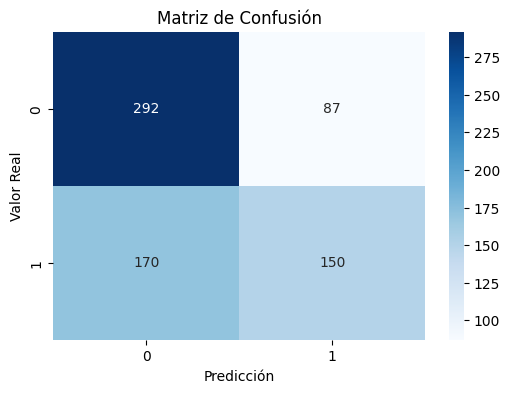

Modelo RandomForestClassifier
Accuracy: 0.6495

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70       379
           1       0.65      0.51      0.57       320

    accuracy                           0.65       699
   macro avg       0.65      0.64      0.64       699
weighted avg       0.65      0.65      0.64       699



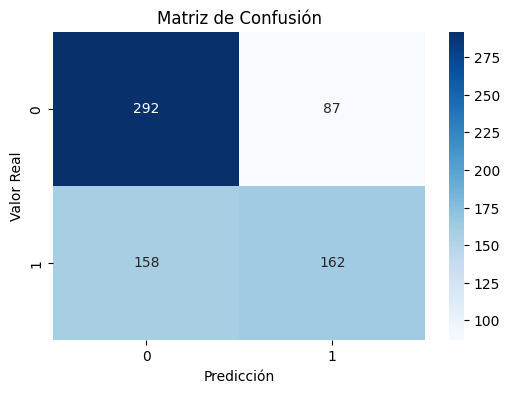

Modelo XGBClassifier
Accuracy: 0.6395

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       379
           1       0.63      0.50      0.56       320

    accuracy                           0.64       699
   macro avg       0.64      0.63      0.63       699
weighted avg       0.64      0.64      0.63       699



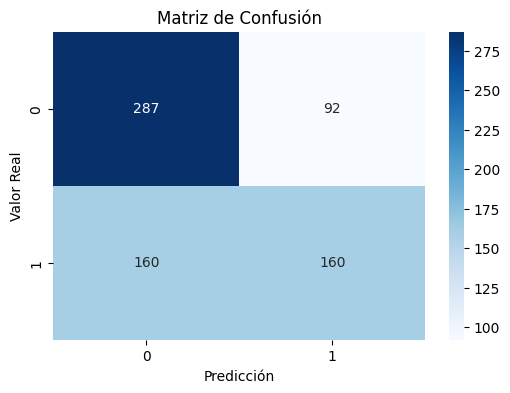

Modelo SVC
Accuracy: 0.6352

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       379
           1       0.62      0.51      0.56       320

    accuracy                           0.64       699
   macro avg       0.63      0.63      0.62       699
weighted avg       0.63      0.64      0.63       699



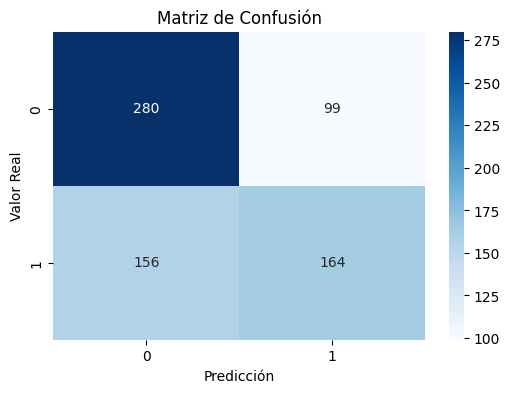

In [ ]:
best_modelo_lr_biomedlm = cargar_modelo('LogisticRegression_biomedlmBEST_mejor_modelo.pkl', 'best_modelo_lr_biomedlm')
best_modelo_rf_biomedlm = cargar_modelo('RandomForestClassifier_biomedlmBEST_mejor_modelo.pkl', 'best_modelo_rf_biomedlm')
best_modelo_xgb_biomedlm = cargar_modelo('XGBClassifier_biomedlmBEST_mejor_modelo.pkl', 'best_modelo_xgb_biomedlm')
best_modelo_svm_biomedlm = cargar_modelo('SVC_biomedlmBEST_mejor_modelo.pkl', 'best_modelo_svm_biomedlm')

# predicciones
best_preds_lr_biomedlm = predicciones(X_biomedlm_val, best_modelo_lr_biomedlm, y=y_val)
best_preds_rf_biomedlm = predicciones(X_biomedlm_val, best_modelo_rf_biomedlm, y=y_val)
best_preds_xgb_biomedlm = predicciones(X_biomedlm_val, best_modelo_xgb_biomedlm, y=y_val)
best_preds_svm_biomedlm = predicciones(X_biomedlm_val, best_modelo_svm_biomedlm, y=y_val)

**2.1.2.2. Bio_ClinicalBERT**

Modelo LogisticRegression
Accuracy: 0.7053

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       379
           1       0.68      0.68      0.68       320

    accuracy                           0.71       699
   macro avg       0.70      0.70      0.70       699
weighted avg       0.71      0.71      0.71       699



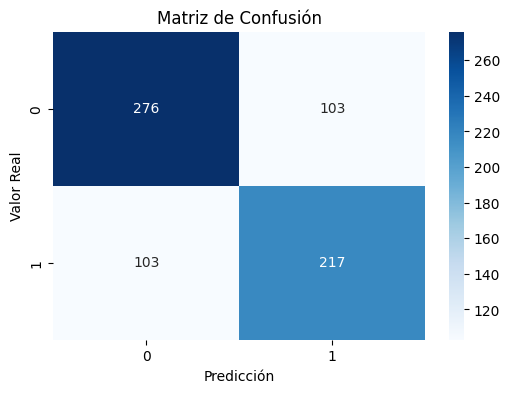

Modelo RandomForestClassifier
Accuracy: 0.6753

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       379
           1       0.67      0.57      0.61       320

    accuracy                           0.68       699
   macro avg       0.67      0.67      0.67       699
weighted avg       0.67      0.68      0.67       699



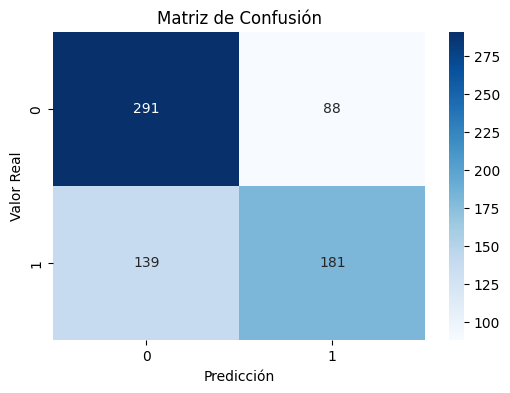

Modelo XGBClassifier
Accuracy: 0.7411

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       379
           1       0.73      0.68      0.71       320

    accuracy                           0.74       699
   macro avg       0.74      0.74      0.74       699
weighted avg       0.74      0.74      0.74       699



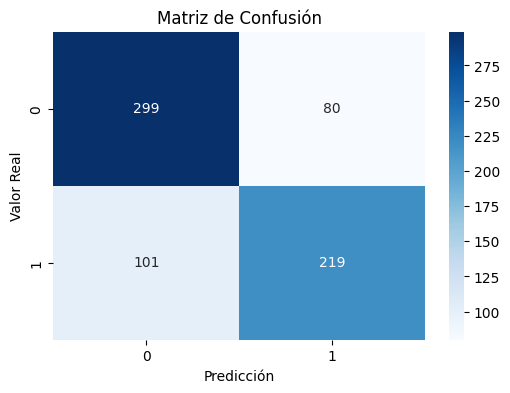

Modelo SVC
Accuracy: 0.7124

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       379
           1       0.69      0.68      0.69       320

    accuracy                           0.71       699
   macro avg       0.71      0.71      0.71       699
weighted avg       0.71      0.71      0.71       699



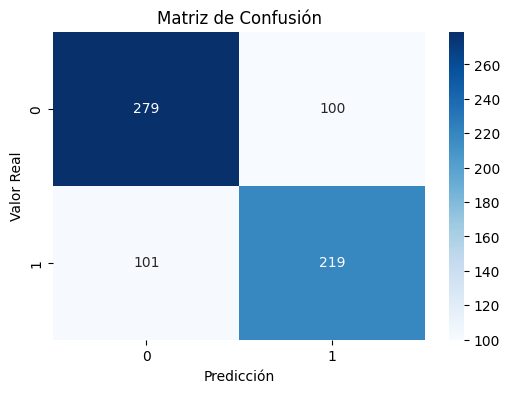

In [ ]:
best_modelo_lr_bioclinical = cargar_modelo('LogisticRegression_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_lr_bioclinical')
best_modelo_rf_bioclinical = cargar_modelo('RandomForestClassifier_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_rf_bioclinical')
best_modelo_xgb_bioclinical = cargar_modelo('XGBClassifier_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_xgb_bioclinical')
best_modelo_svm_bioclinical = cargar_modelo('SVC_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_svm_bioclinical')

# predicciones
best_preds_lr_bioclinical = predicciones(X_bioclinical_val, best_modelo_lr_bioclinical, y=y_val)
best_preds_rf_bioclinical = predicciones(X_bioclinical_val, best_modelo_rf_bioclinical, y=y_val)
best_preds_xgb_bioclinical = predicciones(X_bioclinical_val, best_modelo_xgb_bioclinical, y=y_val)
best_preds_svm_bioclinical = predicciones(X_bioclinical_val, best_modelo_svm_bioclinical, y=y_val)

**2.1.2.3. TF-IDF**

Modelo LogisticRegression
Accuracy: 0.7768

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       379
           1       0.76      0.75      0.76       320

    accuracy                           0.78       699
   macro avg       0.78      0.77      0.78       699
weighted avg       0.78      0.78      0.78       699



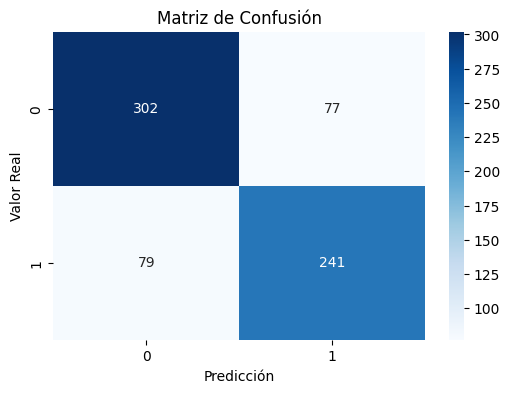

Modelo RandomForestClassifier
Accuracy: 0.7868

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       379
           1       0.78      0.74      0.76       320

    accuracy                           0.79       699
   macro avg       0.79      0.78      0.78       699
weighted avg       0.79      0.79      0.79       699



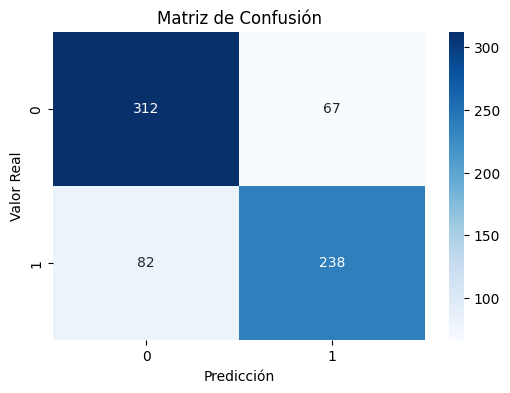

Modelo XGBClassifier
Accuracy: 0.7725

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       379
           1       0.75      0.75      0.75       320

    accuracy                           0.77       699
   macro avg       0.77      0.77      0.77       699
weighted avg       0.77      0.77      0.77       699



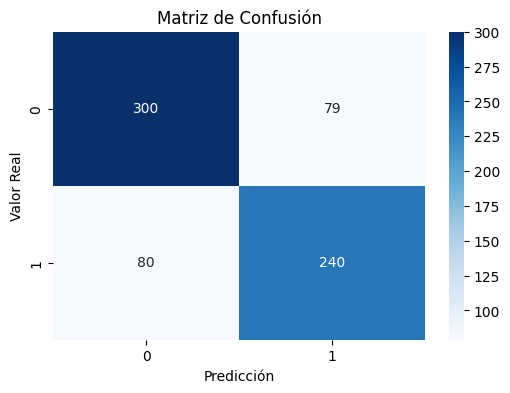

Modelo SVC
Accuracy: 0.7711

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       379
           1       0.75      0.76      0.75       320

    accuracy                           0.77       699
   macro avg       0.77      0.77      0.77       699
weighted avg       0.77      0.77      0.77       699



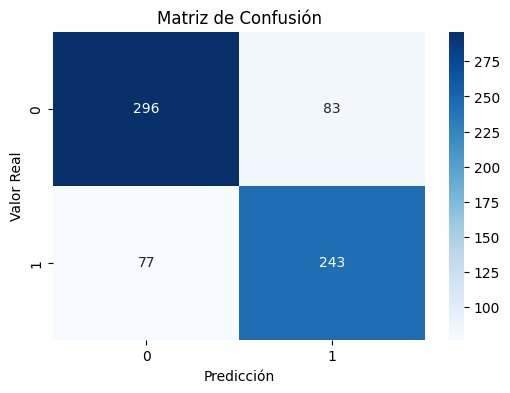

In [ ]:
best_modelo_lr_tfidf = cargar_modelo('LogisticRegression_tfidfBEST_mejor_modelo.pkl', 'best_modelo_lr_tfidf')
best_modelo_rf_tfidf = cargar_modelo('RandomForestClassifier_tfidfBEST_mejor_modelo.pkl', 'best_modelo_rf_tfidf')
best_modelo_xgb_tfidf = cargar_modelo('XGBClassifier_tfidfBEST_mejor_modelo.pkl', 'best_modelo_xgb_tfidf')
best_modelo_svm_tfidf = cargar_modelo('SVC_tfidfBEST_mejor_modelo.pkl', 'best_modelo_svm_tfidf')

# predicciones
best_preds_lr_tfidf = predicciones(X_tfidf_val, best_modelo_lr_tfidf, y=y_val)
best_preds_rf_tfidf = predicciones(X_tfidf_val, best_modelo_rf_tfidf, y=y_val)
best_preds_xgb_tfidf = predicciones(X_tfidf_val, best_modelo_xgb_tfidf, y=y_val)
best_preds_svm_tfidf = predicciones(X_tfidf_val, best_modelo_svm_tfidf, y=y_val)

Viendo el *accuracy* de estos modelos, vemos que la búsqueda inicial no se alejaba tanto de los mejores modelos aquí encontrados por validación cruzada. 

**2.1.2.4. Combinaciones**

Probemos ahora con *ensembles* de estos modelos. Si construimos los mismos que antes, podremos comparar para ver si hay efectivamente una mejora notable o no.

Otras combinaciones con precisión similar:
(0.7882689556509299, (1.1, 0.9, 0.0, 0.6, 2.4))
(0.7896995708154506, (1.1, 0.9, 0.0, 0.5, 2.5))
(0.7911301859799714, (0.8, 0.3, 0.0, 0.9, 3.0))
(0.7925608011444921, (0.8, 0.4, 0.0, 0.5, 3.3))
(0.7968526466380543, (0.2, 0.0, 0.4, 1.0, 3.4))
(0.7939914163090128, (0.3, 0.4, 0.1, 0.9, 3.3))
(0.7954220314735336, (0.2, 0.0, 0.5, 1.2, 3.1))
Pesos del mejor modelo combinado: (0.2, 0.0, 0.4, 1.0, 3.4). Accuracy: 0.7969

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       379
           1       0.78      0.77      0.78       320

    accuracy                           0.80       699
   macro avg       0.80      0.79      0.80       699
weighted avg       0.80      0.80      0.80       699



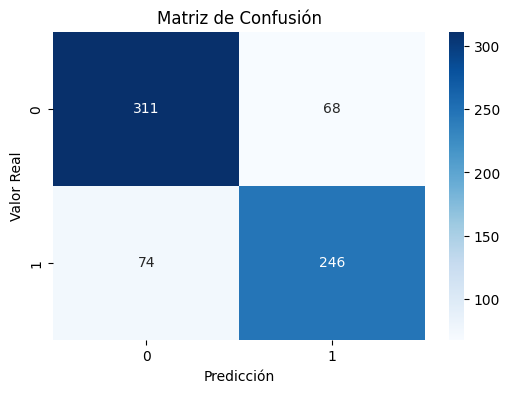

In [ ]:
best_weightsCV = combinacion([best_preds_svm_biomedlm[1], best_preds_xgb_bioclinical[1], best_preds_svm_bioclinical[1], best_preds_lr_tfidf[1], best_preds_rf_tfidf[1]], y_test=y_val, tipo='find_promedio') # encontrar mejores pesos

Si bien hay una mejor sustancial respecto a un modelo con hiperparámetros fijados "a ojo", como en el caso de la primera aproximación, seguimos por debajo de la barrera del 80%. 

**2.1.3. Predicciones sobre los datos de test**

Como la unica mejora sustancial la obtenemos con el *ensemble* anterior, haremos las predicciones sobre los datos de *test* con ese. Para ello, cargamos los modelos necesarios (si no lo están ya) y obtenemos las predicciones de cada uno de ellos.

In [ ]:
best_modelo_svm_biomedlm = cargar_modelo('SVC_biomedlmBEST_mejor_modelo.pkl', 'best_modelo_svm_biomedlm')
best_modelo_xgb_bioclinical = cargar_modelo('XGBClassifier_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_xgb_bioclinical')
best_modelo_svm_bioclinical = cargar_modelo('SVC_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_svm_bioclinical')
best_modelo_lr_tfidf = cargar_modelo('LogisticRegression_tfidfBEST_mejor_modelo.pkl', 'best_modelo_lr_tfidf')
best_modelo_rf_tfidf = cargar_modelo('RandomForestClassifier_tfidfBEST_mejor_modelo.pkl', 'best_modelo_rf_tfidf')

best_preds_svm_biomedlm_test = predicciones(X_biomedlm_prueba, best_modelo_svm_biomedlm, data=df_new, filename='best_predicciones_svm_biomedlm_test')
best_preds_xgb_bioclinical_test = predicciones(X_bioclinical_prueba, best_modelo_xgb_bioclinical, data=df_new, filename='best_predicciones_xgb_bioclinical_test')
best_preds_svm_bioclinical_test = predicciones(X_bioclinical_prueba, best_modelo_svm_bioclinical, data=df_new, filename='best_predicciones_svm_bioclinical_test')
best_preds_lr_tfidf_test = predicciones(X_tfidf_prueba, best_modelo_lr_tfidf, data=df_new, filename='best_predicciones_lr_tfidf_test')
best_preds_rf_tfidf_test = predicciones(X_tfidf_prueba, best_modelo_rf_tfidf, data=df_new, filename='best_predicciones_rf_tfidf_test')

Y para sacar las predicciones, los combinamos con los pesos que daban el mejor resultado, `best_weightsCV`. 

In [ ]:
combinacion([best_preds_svm_biomedlm_test[1], best_preds_xgb_bioclinical_test[1], best_preds_svm_bioclinical_test[1], best_preds_lr_tfidf_test[1], best_preds_rf_tfidf_test[1]], w=list(best_weightsCV), save=[df_new, 'best_svm_biomed_xgb_svm_bioclinical_lr_rf_tfidf'], tipo='promedio') # promedio pesado

**2.2. Pasajes resumidos**

**2.2.1. Entrenamiento de modelos**

Ahora repetimos el proceso anterior, pero usando las representaciones obtenidas para los pasajes resumidos por T5.

In [110]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

best_modelo_lr_biomedlmResumen = mejorModeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='lr', data_type='biomedlmResumenBEST')
best_modelo_lr_bioclinicalResumen = mejorModeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='lr', data_type='bioclinicalResumenBEST')
best_modelo_lr_tfidfResumen = mejorModeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='lr', data_type='tfidfResumenBEST')

best_modelo_svm_biomedlmResumen = mejorModeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='svm', data_type='biomedlmResumenBEST')
best_modelo_svm_bioclinicalResumen = mejorModeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='svm', data_type='bioclinicalResumenBEST')
best_modelo_svm_tfidfResumen = mejorModeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='svm', data_type='tfidfResumenBEST')

best_modelo_rf_biomedlmResumen = mejorModeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='rf', data_type='biomedlmResumenBEST')
best_modelo_rf_bioclinicalResumen = mejorModeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='rf', data_type='bioclinicalResumenBEST')
best_modelo_rf_tfidfResumen = mejorModeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='rf', data_type='tfidfResumenBEST')

best_modelo_xgb_biomedlmResumen = mejorModeloClasificacion(X_biomedlm_trainResumen, y_trainResumen, type_model='xgb', data_type='biomedlmResumenBEST')
best_modelo_xgb_bioclinicalResumen = mejorModeloClasificacion(X_bioclinical_trainResumen, y_trainResumen, type_model='xgb', data_type='bioclinicalResumenBEST')
best_modelo_xgb_tfidfResumen = mejorModeloClasificacion(X_tfidf_trainResumen, y_trainResumen, type_model='xgb', data_type='tfidfResumenBEST')


Mejores hiperparámetros para lr: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación (accuracy): 0.5801
Modelo guardado como: LogisticRegression_biomedlmResumenBEST_mejor_modelo.pkl
Mejores hiperparámetros para lr: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación (accuracy): 0.6466
Modelo guardado como: LogisticRegression_bioclinicalResumenBEST_mejor_modelo.pkl
Mejores hiperparámetros para lr: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación (accuracy): 0.7303
Modelo guardado como: LogisticRegression_tfidfResumenBEST_mejor_modelo.pkl
Mejores hiperparámetros para svm: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Mejor puntuación (accuracy): 0.5873
Modelo guardado como: SVC_biomedlmResumenBEST_mejor_modelo.pkl
Mejores hiperparámetros para svm: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Mejor puntuación (accuracy): 0.6509
Modelo guardado como: SVC_bioclinicalResumenBEST_mejor_modelo.pkl
Mejores hiperparámetros para svm: {'C': 1, 'ga

**2.2.2. Evaluación de modelos**

Evaluamos los modelos obtenidos por búsqueda de hiperparámetros.

**2.2.2.1. BioMedLM**

Modelo LogisticRegression
Accuracy: 0.5665

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       379
           1       0.53      0.49      0.51       320

    accuracy                           0.57       699
   macro avg       0.56      0.56      0.56       699
weighted avg       0.56      0.57      0.56       699



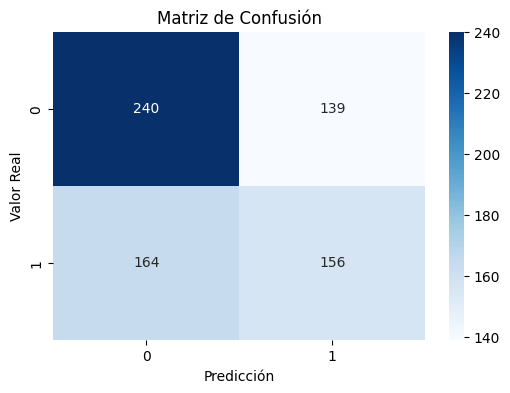

Modelo RandomForestClassifier
Accuracy: 0.5808

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       379
           1       0.55      0.51      0.53       320

    accuracy                           0.58       699
   macro avg       0.58      0.58      0.58       699
weighted avg       0.58      0.58      0.58       699



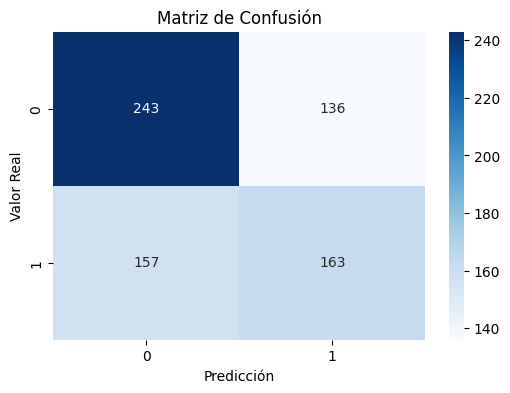

Modelo XGBClassifier
Accuracy: 0.5708

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       379
           1       0.53      0.50      0.51       320

    accuracy                           0.57       699
   macro avg       0.57      0.57      0.56       699
weighted avg       0.57      0.57      0.57       699



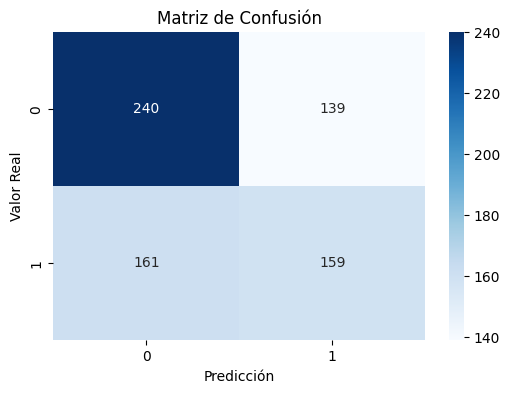

Modelo SVC
Accuracy: 0.5708

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       379
           1       0.53      0.48      0.51       320

    accuracy                           0.57       699
   macro avg       0.57      0.56      0.56       699
weighted avg       0.57      0.57      0.57       699



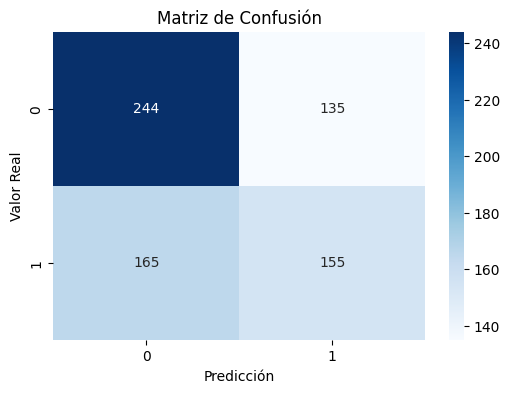

In [111]:
best_modelo_lr_biomedlmResumen = cargar_modelo('LogisticRegression_biomedlmResumenBEST_mejor_modelo.pkl', 'best_modelo_lr_biomedlmResumen')
best_modelo_rf_biomedlmResumen = cargar_modelo('RandomForestClassifier_biomedlmResumenBEST_mejor_modelo.pkl', 'best_modelo_rf_biomedlmResumen')
best_modelo_xgb_biomedlmResumen = cargar_modelo('XGBClassifier_biomedlmResumenBEST_mejor_modelo.pkl', 'best_modelo_xgb_biomedlmResumen')
best_modelo_svm_biomedlmResumen = cargar_modelo('SVC_biomedlmResumenBEST_mejor_modelo.pkl', 'best_modelo_svm_biomedlmResumen')

# predicciones
best_preds_lr_biomedlmResumen = predicciones(X_biomedlm_valResumen, best_modelo_lr_biomedlmResumen, y=y_valResumen)
best_preds_rf_biomedlmResumen = predicciones(X_biomedlm_valResumen, best_modelo_rf_biomedlmResumen, y=y_valResumen)
best_preds_xgb_biomedlmResumen = predicciones(X_biomedlm_valResumen, best_modelo_xgb_biomedlmResumen, y=y_valResumen)
best_preds_svm_biomedlmResumen = predicciones(X_biomedlm_valResumen, best_modelo_svm_biomedlmResumen, y=y_valResumen)

**2.2.2.2. Bio_ClinicalBERT**

Modelo LogisticRegression
Accuracy: 0.6423

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       379
           1       0.62      0.57      0.59       320

    accuracy                           0.64       699
   macro avg       0.64      0.64      0.64       699
weighted avg       0.64      0.64      0.64       699



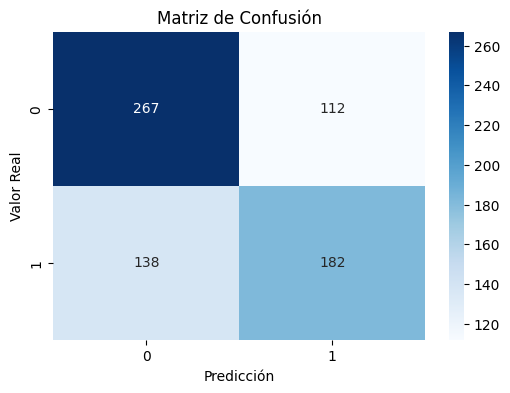

Modelo RandomForestClassifier
Accuracy: 0.6237

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       379
           1       0.63      0.44      0.52       320

    accuracy                           0.62       699
   macro avg       0.62      0.61      0.61       699
weighted avg       0.62      0.62      0.61       699



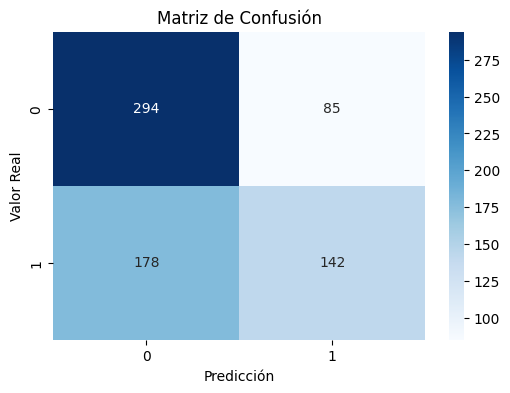

Modelo XGBClassifier
Accuracy: 0.6094

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67       379
           1       0.59      0.48      0.53       320

    accuracy                           0.61       699
   macro avg       0.61      0.60      0.60       699
weighted avg       0.61      0.61      0.60       699



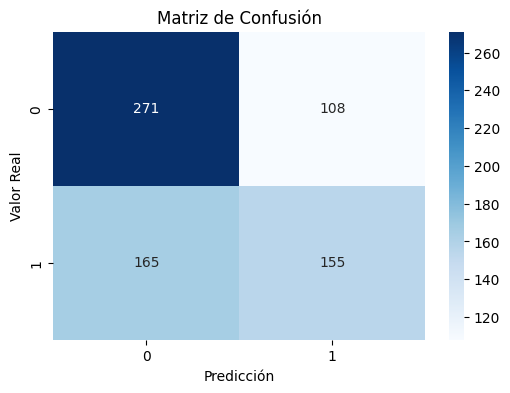

Modelo SVC
Accuracy: 0.6495

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       379
           1       0.62      0.60      0.61       320

    accuracy                           0.65       699
   macro avg       0.65      0.65      0.65       699
weighted avg       0.65      0.65      0.65       699



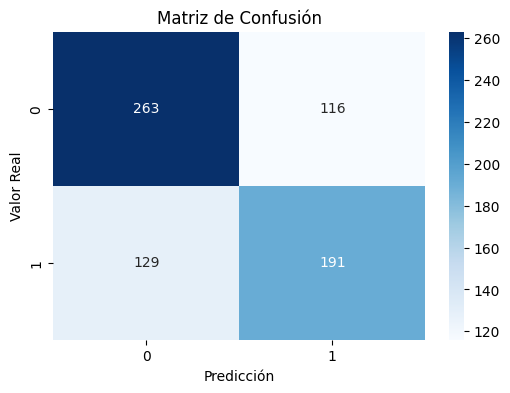

In [112]:
best_modelo_lr_bioclinicalResumen = cargar_modelo('LogisticRegression_bioclinicalResumenBEST_mejor_modelo.pkl', 'best_modelo_lr_bioclinicalResumen')
best_modelo_rf_bioclinicalResumen = cargar_modelo('RandomForestClassifier_bioclinicalResumenBEST_mejor_modelo.pkl', 'best_modelo_rf_bioclinicalResumen')
best_modelo_xgb_bioclinicalResumen = cargar_modelo('XGBClassifier_bioclinicalResumenBEST_mejor_modelo.pkl', 'best_modelo_xgb_bioclinicalResumen')
best_modelo_svm_bioclinicalResumen = cargar_modelo('SVC_bioclinicalResumenBEST_mejor_modelo.pkl', 'best_modelo_svm_bioclinicalResumen')

# predicciones
best_preds_lr_bioclinicalResumen = predicciones(X_bioclinical_valResumen, best_modelo_lr_bioclinicalResumen, y=y_valResumen)
best_preds_rf_bioclinicalResumen = predicciones(X_bioclinical_valResumen, best_modelo_rf_bioclinicalResumen, y=y_valResumen)
best_preds_xgb_bioclinicalResumen = predicciones(X_bioclinical_valResumen, best_modelo_xgb_bioclinicalResumen, y=y_valResumen)
best_preds_svm_bioclinicalResumen = predicciones(X_bioclinical_valResumen, best_modelo_svm_bioclinicalResumen, y=y_valResumen)

**2.2.2.3. TF-IDF**

Modelo LogisticRegression
Accuracy: 0.7496

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       379
           1       0.75      0.68      0.71       320

    accuracy                           0.75       699
   macro avg       0.75      0.74      0.75       699
weighted avg       0.75      0.75      0.75       699



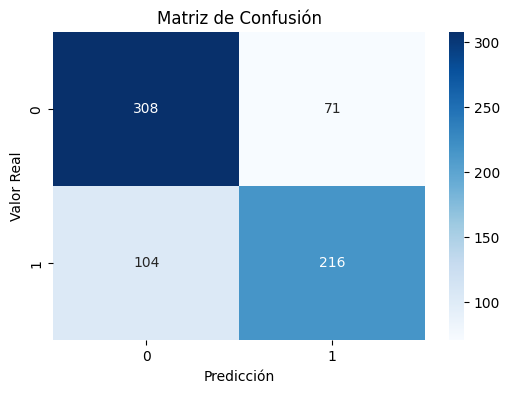

Modelo RandomForestClassifier
Accuracy: 0.7611

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       379
           1       0.76      0.70      0.73       320

    accuracy                           0.76       699
   macro avg       0.76      0.76      0.76       699
weighted avg       0.76      0.76      0.76       699



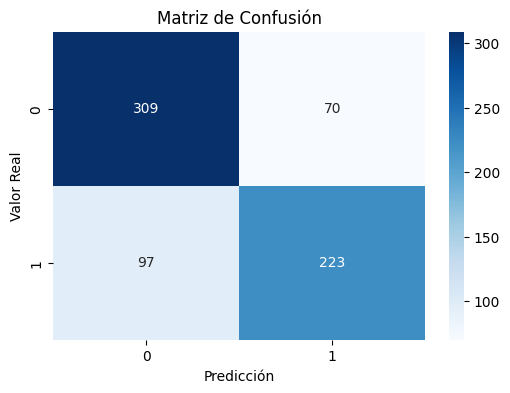

Modelo XGBClassifier
Accuracy: 0.7268

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       379
           1       0.70      0.70      0.70       320

    accuracy                           0.73       699
   macro avg       0.72      0.72      0.72       699
weighted avg       0.73      0.73      0.73       699



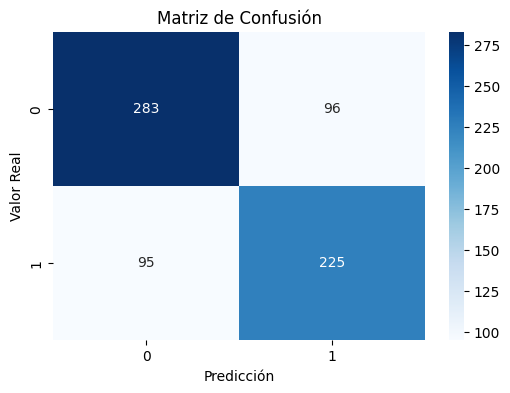

Modelo SVC
Accuracy: 0.7611

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       379
           1       0.77      0.68      0.72       320

    accuracy                           0.76       699
   macro avg       0.76      0.76      0.76       699
weighted avg       0.76      0.76      0.76       699



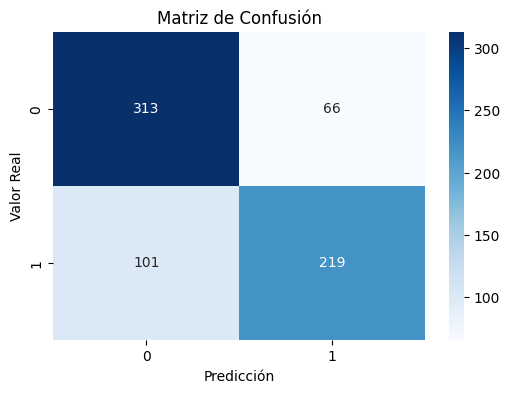

In [113]:
best_modelo_lr_tfidfResumen = cargar_modelo('LogisticRegression_tfidfResumenBEST_mejor_modelo.pkl', 'best_modelo_lr_tfidfResumen')
best_modelo_rf_tfidfResumen = cargar_modelo('RandomForestClassifier_tfidfResumenBEST_mejor_modelo.pkl', 'best_modelo_rf_tfidfResumen')
best_modelo_xgb_tfidfResumen = cargar_modelo('XGBClassifier_tfidfResumenBEST_mejor_modelo.pkl', 'best_modelo_xgb_tfidfResumen')
best_modelo_svm_tfidfResumen = cargar_modelo('SVC_tfidfResumenBEST_mejor_modelo.pkl', 'best_modelo_svm_tfidfResumen')

# predicciones
best_preds_lr_tfidfResumen = predicciones(X_tfidf_valResumen, best_modelo_lr_tfidfResumen, y=y_valResumen)
best_preds_rf_tfidfResumen = predicciones(X_tfidf_valResumen, best_modelo_rf_tfidfResumen, y=y_valResumen)
best_preds_xgb_tfidfResumen = predicciones(X_tfidf_valResumen, best_modelo_xgb_tfidfResumen, y=y_valResumen)
best_preds_svm_tfidfResumen = predicciones(X_tfidf_valResumen, best_modelo_svm_tfidfResumen, y=y_valResumen)

De nuevo se repiten los resultados encontrados al comparar los resultados obtenidos con pasajes resumidos o sin resumir. Podemos concluir por tanto que la estrategia de resumir los pasajes antes de obtener las representaciones de *embeddings* no es adecuada para este problema de clasificación.

**2.2.2.4. Combinaciones**

Otras combinaciones con precisión similar:
(0.7625178826895566, (0.9, 0.4, 0.5, 2.2))
(0.7639484978540773, (0.9, 0.4, 0.6, 2.1))
(0.765379113018598, (0.8, 0.4, 1.0, 1.8))
(0.7682403433476395, (0.5, 0.3, 1.5, 1.7))
(0.7668097281831188, (0.7, 0.6, 1.1, 1.6))
(0.7696709585121603, (0.1, 0.2, 2.9, 0.8))
(0.771101573676681, (0.0, 0.2, 2.9, 0.9))
Pesos del mejor modelo combinado: (0.0, 0.2, 2.9, 0.9). Accuracy: 0.7711

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       379
           1       0.78      0.70      0.74       320

    accuracy                           0.77       699
   macro avg       0.77      0.77      0.77       699
weighted avg       0.77      0.77      0.77       699



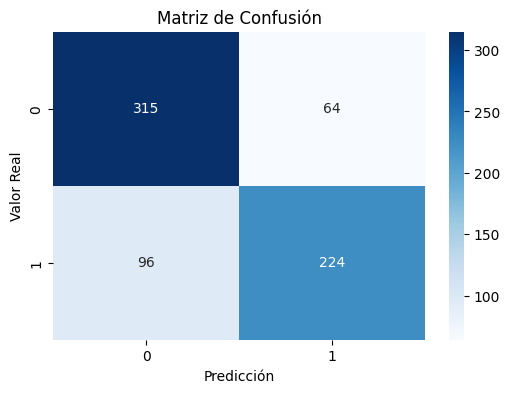

In [115]:
best_weightsCVResumen = combinacion([best_preds_rf_biomedlmResumen[1], best_preds_svm_bioclinicalResumen[1], best_preds_rf_tfidfResumen[1], best_preds_svm_tfidfResumen[1]], y_test=y_val, tipo='find_promedio') # encontrar mejores pesos

**2.2.3. Predicciones sobre los datos de test**

In [ ]:
best_modelo_rf_biomedlmResumen = cargar_modelo('RandomForestClassifier_biomedlmBEST_mejor_modelo.pkl', 'best_modelo_rf_biomedlmResuem')
best_modelo_svm_bioclinicalResumen = cargar_modelo('SVC_bioclinicalBEST_mejor_modelo.pkl', 'best_modelo_svm_bioclinicalResumen')
best_modelo_svm_tfidfResumen = cargar_modelo('SVC_tfidfBEST_mejor_modelo.pkl', 'best_modelo_svm_tfidfResumen')
best_modelo_rf_tfidfResumen = cargar_modelo('RandomForestClassifier_tfidfBEST_mejor_modelo.pkl', 'best_modelo_rf_tfidfResumen')

best_preds_rf_biomedlm_testResumen = predicciones(X_biomedlm_testResumen, best_modelo_rf_biomedlmResumen, data=data_embeddingsResumen_test, filename='best_predicciones_svm_biomedlm_testResumen')
best_preds_svm_bioclinical_testResumen = predicciones(X_bioclinical_testResumen, best_modelo_svm_bioclinicalResumen, data=data_embeddingsResumen_test, filename='best_predicciones_svm_bioclinical_testResumen')
best_preds_svm_tfidf_testResumen = predicciones(X_tfidf_testResumen, best_modelo_svm_tfidfResumen, data=data_embeddingsResumen_test, filename='best_predicciones_lr_tfidf_testResumen')
best_preds_rf_tfidf_testResumen = predicciones(X_tfidf_testResumen, best_modelo_rf_tfidfResumen, data=data_embeddingsResumen_test, filename='best_predicciones_rf_tfidf_testResumen')

# combinamos las predicciones
combinacion([best_preds_rf_biomedlm_testResumen[1], best_preds_svm_bioclinical_testResumen[1], best_preds_rf_tfidf_testResumen[1], best_preds_svm_tfidf_testResumen[1]], w=list(best_weightsCVResumen), save=[data_embeddingsResumen_test, 'best_testResumen_svm_biomed_xgb_svm_bioclinical_lr_rf_tfidf'], tipo='promedio') # promedio pesado

## Finetuning

In [ ]:
train_data, val_data
train_dataResumen, val_dataResumen

Finetuning truncando

In [128]:
from datasets import Dataset

# Convertir a Dataset de Hugging Face
train_dataset = Dataset.from_pandas(train_data.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_data.reset_index(drop=True))
# Distribución en el conjunto de entrenamiento
print("Distribución en el conjunto de entrenamiento:")
print(train_data['correctness'].value_counts())

# Distribución en el conjunto de validación
print("\nDistribución en el conjunto de validación:")
print(val_data['correctness'].value_counts())

Distribución en el conjunto de entrenamiento:
correctness
0    1517
1    1279
Name: count, dtype: int64

Distribución en el conjunto de validación:
correctness
0    379
1    320
Name: count, dtype: int64


In [131]:
from transformers import AutoModelForSequenceClassification

def preprocess_data(examples, tokenizer = bert_tokenizer, longitud = 512):
    # Combinar 'topic' y 'cleaned_passage'
    texts = ["[CLS] " + t + " [SEP] " + p for t, p in zip(examples['topic_text'], examples['cleaned_passage'])]
    # Tokenizar
    encoding = tokenizer(texts, padding="max_length", truncation=True, max_length=longitud)
    # Agregar las etiquetas
    encoding["labels"] = examples["correctness"]
    return encoding

train_dataset = train_dataset.map(lambda examples: preprocess_data(examples), batched=True)
val_dataset = val_dataset.map(lambda examples: preprocess_data(examples), batched=True)

# 4. Crear conjuntos de datos tokenizados

columns = ['input_ids', 'attention_mask', 'labels']
train_dataset.set_format(type='torch', columns=columns)
val_dataset.set_format(type='torch', columns=columns)
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)

# 6. Definir los argumentos de entrenamiento

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    no_cuda=True,
)

# 7. Definir las métricas de evaluación
from sklearn.metrics import precision_recall_fscore_support
from transformers import Trainer

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# 8. Entrenar el modelo
tqdm.pandas()  # Para mostrar una barra de progreso

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# 9. Evaluar el modelo

prediction_output = trainer.predict(val_dataset)

# Obtener las predicciones y convertir logits a etiquetas predichas
predictions = np.argmax(prediction_output.predictions, axis=1)

# Obtener las etiquetas reales
true_labels = prediction_output.label_ids
evaluacion(true_labels, predictions)
"""
# 10. Realizar inferencias

def predict(question, passage):
    text = "[CLS] " + question + " [SEP] " + passage
    encoding = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    outputs = model(**encoding)
    logits = outputs.logits
    prediction = logits.argmax(-1).item()
    return prediction

# Ejemplo de uso
question = "What are the symptoms of diabetes?"
passage = "Diabetes is a chronic disease that occurs when the body can't produce enough insulin or can't use it effectively."
prediction = predict(question, passage)
print("Predicción:", prediction)  # 0 o 1
"""

Map: 100%|██████████| 699/699 [00:01<00:00, 367.04 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/luisi/Documents/Master-Big-Data/Tecnologías de gestión de información no estructurada/.venv/lib/python3.11/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_23553/1697430732.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(

  0%|          | 0/2097 [47:43<?, ?it/s]            

{'loss': 0.6209, 'grad_norm': 2.8638033866882324, 'learning_rate': 1.5231282784930855e-05, 'epoch': 0.72}



















































































































































































                                           
                                                      
  0%|          | 0/2097 [1:06:55<?, ?it/s]


{'eval_loss': 0.5256025195121765, 'eval_accuracy': 0.7567954220314735, 'eval_f1': 0.7128378378378378, 'eval_precision': 0.7757352941176471, 'eval_recall': 0.659375, 'eval_runtime': 132.9916, 'eval_samples_per_second': 5.256, 'eval_steps_per_second': 1.316, 'epoch': 1.0}



  0%|          | 0/2097 [1:39:48<?, ?it/s]             

{'loss': 0.5102, 'grad_norm': 7.044665813446045, 'learning_rate': 1.046256556986171e-05, 'epoch': 1.43}


















































































































































































                                                     

  0%|          | 0/2097 [2:17:14<?, ?it/s]       



{'eval_loss': 0.5265010595321655, 'eval_accuracy': 0.7782546494992847, 'eval_f1': 0.7655068078668684, 'eval_precision': 0.7419354838709677, 'eval_recall': 0.790625, 'eval_runtime': 126.3595, 'eval_samples_per_second': 5.532, 'eval_steps_per_second': 1.385, 'epoch': 2.0}



  0%|          | 0/2097 [2:25:25<?, ?it/s]           

{'loss': 0.514, 'grad_norm': 22.539798736572266, 'learning_rate': 5.693848354792561e-06, 'epoch': 2.15}



  0%|          | 0/2097 [3:05:25<?, ?it/s]           

{'loss': 0.4438, 'grad_norm': 8.321715354919434, 'learning_rate': 9.251311397234144e-07, 'epoch': 2.86}


KeyboardInterrupt: 

Finetuning solo con resumenes o truncando RuntimeError: The expanded size of the tensor (2000) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [4, 2000].  Tensor sizes: [1, 512]
